# Are cyber attacks becoming more diverse, or do the same attack patterns keep repeating ?
By Camille Rouan & Sacha Sagratella \
Supervised by Louis Olive

# I. Motivation 



Cyber incidents are a growing (and already installed) risk for many actors, such as firms, organizations, states and individuals.


With the rise of technology and digitalization of society, the digital economy is now an important part of the global economy. Whenever something generates money crime follows, this is no exception to the rule. \
Cyber attack incidents can come from activists, states as well as terrorists, there can be many methods of attacks, many methods of defense... This is a very complete subject. According to Interpol, "The total value lost to cybercrime yearly is now comparable to the gross domestic product of major economies". Many economists are concerned about the subject and want to study these new risks in the economy. \
For example, Vergara Cobos, Estefania; and Cakir, Selcen. 2024. 'A Review of the Economic Costs of Cyber Incidents. Washington, DC: World Bank", presented a review of the existing research on costs incurred
from cyber incidents. To wrap up, they came to the conclusion that (economic) costs due to cyber incidents are composed of direct costs, indirect costs potentially as large as direct ones and continuous response costs. This article shows that costs due to cyber criminality have an important (direct and indirect) impact on the economy.

As we know the current and even growing importance of cyber incidents, we decided to study them to try to better understand, to analyse and prevent them to help states, firms and individuals. Precisely, we want to know if cyber attacks are becoming more diverse, or do the same attack patterns keep repeating. For that we will do a data-driven analysis in two main parts, first the Data Analysis process presenting the data collection, preparation and analysis. Then, the second part will present our findings including conclusions, impact and further recommendations. 

# II. Data Analysis Process

This part will include the data presentation, exploration and analysis.

We use a dataset from the European Repository of Cyber incidents (EuRepoC), this is an "independent research consortium dedicated to providing evidence-based scientific analysis of cyber incidents" (EuRepoc website). The dataset is quite complete, one observation corresponds to one cyber incident all over the world. The time period used in this analysis is from 2000 to 2024 but the dataset is frequently updated. Each cyber incident is decribed by more than 80 variables, we will only focus on few of them. The data were available for free and in many formats (CSV or Excel). The dataset contains 3416 cyber incident.\
The main challenge was to find (free) data about cyber incidents, indeed there is few database on this topic as it is a recent topic and due to the difficulty to obtain data on that, either from the criminals and either from the victims. This is a potential bias for our analysis.


## 1.Data Preparation

In [1]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy
import warnings

# Ignore all the warnings
warnings.filterwarnings('ignore')

In [2]:

df = pd.read_csv("D:/M2 - Economics of Global Risks (EGR)/Python cours/Projet python/eurepoc_global_dataset_1_3.csv")

print(df.info())
print(df.columns)
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3414 entries, 0 to 3413
Data columns (total 85 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   incident_id                            3414 non-null   int64 
 1   name                                   3414 non-null   object
 2   description                            3414 non-null   object
 3   start_date                             3414 non-null   object
 4   end_date                               3414 non-null   object
 5   inclusion_criterion                    3414 non-null   object
 6   inclusion_criterion_subcode            3414 non-null   object
 7   source_disclosure                      3414 non-null   object
 8   incident_type                          3414 non-null   object
 9   receiver_name                          3414 non-null   object
 10  receiver_country                       3414 non-null   object
 11  receiver_country_

In [3]:

# ======================================================
# Missing values exploration & cleaning
# ======================================================
# Missing values are coded as:
# "Not attributed", "Not available", "Unknown", or empty

missing_patterns = ["Not available", "Not attributed", "Unknown"]

# Count each type of missing value per column
missing_counts = {
    pattern: df.astype(str).apply(
        lambda col: col.str.contains(pattern, case=False, na=False).sum()
    )
    for pattern in missing_patterns}

# Replace textual missing values by NaN
df = df.replace(
    to_replace=r'(?i)(not available|not attributed|unknown)(;( )?\1)*',
    value=np.nan,
    regex=True)

# Summary of missing values
na_summary = pd.DataFrame({"number_NA": df.isna().sum(),"prop_NA": df.isna().mean() * 100})

print(na_summary)
print("Total NA:", df.isna().sum().sum())
print("Total available values:", df.count().sum())


                    number_NA     prop_NA
incident_id                 0    0.000000
name                      646   18.922086
description               669   19.595782
start_date                 92    2.694786
end_date                 1873   54.862332
...                       ...         ...
response_indicator       1461   42.794376
casualties               3414  100.000000
source_url                 41    1.200937
added_to_db                 0    0.000000
updated_at                  0    0.000000

[85 rows x 2 columns]
Total NA: 127081
Total available values: 163109


In [4]:
# Remove variables with too many missing values

df_clean = df.loc[:, na_summary["prop_NA"] < 80]
print(df_clean.shape)

(3414, 63)


In [5]:

# Time variables & duration

df_clean["start_date"] = pd.to_datetime(df_clean["start_date"])
df_clean["end_date"] = pd.to_datetime(df_clean["end_date"])

# Creation of a variable "duration_incidents"
df_clean["duration_incidents"] = (
    df_clean["end_date"] - df_clean["start_date"]).dt.days


In [6]:
#  Utility function: split semi-colon variables (Useful for the analysis of the dataset as 
# some variable are encoded with multiple indicators by cells )

def split_unique(values):
    """Split semi-colon separated values and return unique elements."""
    if pd.isna(values):
        return []
    parts = [v.strip() for v in str(values).split(";") if v.strip() != ""]
    return list(dict.fromkeys(parts))



## 2.Data Exploration

First, we want to make an exploration by countries, indeed we want to know more from where the attacks come from and to where they are directed.
We decided to "explode" each cell to create one observations for each country for each cyber incidents for simplicity.

In [7]:

# ======================================================
#  Receiver countries analysis
# ======================================================

df_receiver = df_clean.copy()
df_receiver["receiver_country_exp"] = df_receiver["receiver_country"].apply(split_unique)

df_receiver = (
    df_receiver
    .explode("receiver_country_exp")
    .dropna(subset=["receiver_country_exp"]))

attacks_receiver = (
    df_receiver["receiver_country_exp"]
    .value_counts()
    .rename_axis("country")
    .reset_index(name="number_of_attacks"))

print(attacks_receiver)

# Mapping plot
fig = px.choropleth(
    attacks_receiver,
    locations="country",
    locationmode="country names",
    color="number_of_attacks",
    color_continuous_scale="Reds",
    title="Number of cyberattacks by receiving countries")

fig.update_layout(
    title_y=0.83,
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=False),
    coloraxis_colorbar=dict(title="Number of cyber attacks")
)

fig.write_image("cyberattacks_map.png", width=1200, height=600, scale=2)
fig.show()

                                        country  number_of_attacks
0                                 United States                843
1                                        Russia                218
2                                       Germany                165
3                                United Kingdom                156
4                                        Israel                147
..                                          ...                ...
197                                    Anguilla                  1
198                                      Panama                  1
199                                     Bahamas                  1
200  United Nations Economic and Social Council                  1
201        United Nations Environment Programme                  1

[202 rows x 2 columns]


We can clearly see that USA is the leader of attack received (843), followed by Russia (218) and Germany (165).

In [8]:

# ======================================================
#  Initiator countries analysis
# ======================================================

df_initiator = df_clean.copy()
df_initiator["initiator_country_exp"] = df_initiator["initiator_country"].apply(split_unique)

df_initiator = (df_initiator.explode("initiator_country_exp").dropna(subset=["initiator_country_exp"]))

attacks_initiator = (df_initiator["initiator_country_exp"].value_counts().rename_axis("country").reset_index(name="number_of_attacks"))

print(attacks_initiator)

# Mapping plot
fig = px.choropleth(
    attacks_initiator,
    locations="country",
    locationmode="country names",
    color="number_of_attacks",
    color_continuous_scale="Reds",
    title="Number of cyberattacks by initiator countries")

fig.update_layout(
    title_y=0.83,
    title_x=0.5,
    geo=dict(showframe=False, showcoastlines=False),
    coloraxis_colorbar=dict(title="Number of cyber attacks"))

fig.show()


                                    country  number_of_attacks
0                                    Russia                364
1                                     China                334
2                 Iran, Islamic Republic of                154
3    Korea, Democratic People's Republic of                151
4                                   Ukraine                 82
..                                      ...                ...
107                                  Panama                  1
108                                    Iraq                  1
109                                 Georgia                  1
110                   Israel, United States                  1
111                              Kyrgyzstan                  1

[112 rows x 2 columns]


For initiator countrie, Russia is the leader with 364 attacks initiated, then China (334) and Iran (154).
There is an issue with the plot, and we do not suceed to fix it: Russia and China are the most iniator countries but they do not appear in red in the map. The number of attacks is well counted but the color dosen't work only for these 2 countries.

Now, we want to study the variable receiver_category. We would like to know the proportion of each categories targeted, what are the main sectors targeted. In total, we have 10 categories, but some have subcategories. The dataset has not yet classified by numbers the different modalities (as in the databook), so we did it. By looking at the dataset, we observe that for a same observation, a modality can appear several times. Therefore, when coding each modality, we remove the duplicates. Sometimes, some categories which do not belong to any of the 10 modalities listed appear. We grouped them with the modality 9 (other).
Then, we will take care of the multiple codings.

In [9]:

    # ======================================================
    #  Receiver category encoding
    # ======================================================

# mapping
category_mapping = {
        "Unknown": 0,
        "State institutions / political system": 1,
        "International / supranational organization": 2,
        "Critical infrastructure": 3,
        "Social groups": 4,
        "Corporate Targets (corporate targets only coded if the respective company is not part of the critical infrastructure definition)": 5,
        "End user(s) / specially protected groups": 6,
        "Media": 7,
        "Science": 8,
        "Other": 9
        }

def encode_receiver_category(value):
        if pd.isna(value):
            return None
        
        categories = [v.strip() for v in str(value).split(";")]
        unique_categories = set(categories)
        codes = {str(category_mapping.get(cat, 9)) for cat in unique_categories}
        
        return ";".join(sorted(codes))


df_clean["receiver_category_code"] = df_clean["receiver_category"].apply(
        encode_receiver_category
    )

print(df_clean[["receiver_category", "receiver_category_code"]].head(20))



                                    receiver_category receiver_category_code
0               State institutions / political system                      1
1   Critical infrastructure;Corporate Targets (cor...                    3;5
2   Corporate Targets (corporate targets only code...                      5
3   Corporate Targets (corporate targets only code...                    3;5
4               State institutions / political system                      1
5                             Critical infrastructure                      3
6                             Critical infrastructure                      3
7   Critical infrastructure;Critical infrastructur...                    3;5
8   Critical infrastructure;Corporate Targets (cor...                    3;5
9               State institutions / political system                      1
10    Critical infrastructure;Critical infrastructure                      3
11                            Critical infrastructure                      3

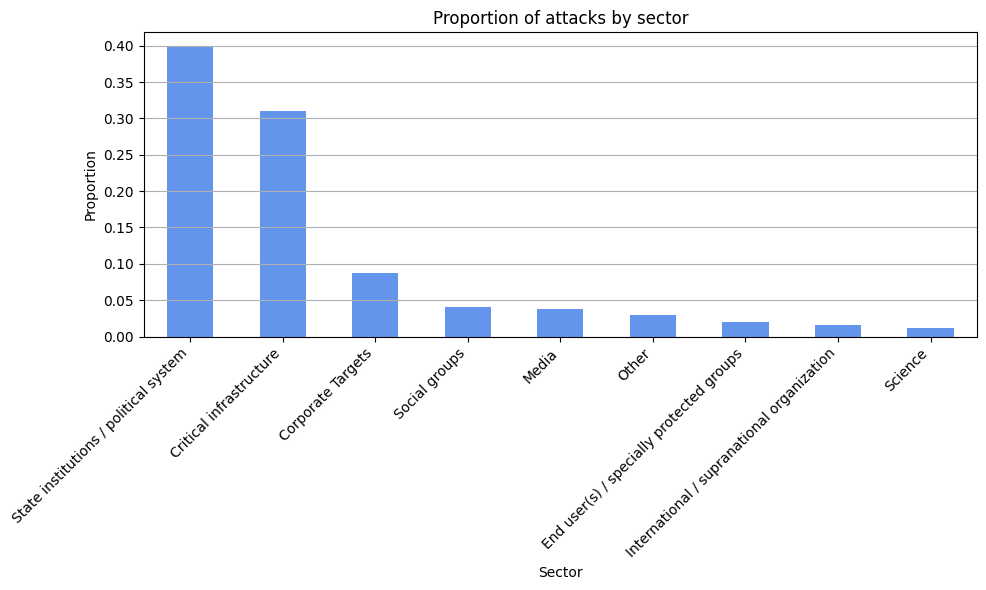

In [10]:
# ======================================================
#  Sector weighting & proportions
# ======================================================

df_clean["receiver_category_code_list"] = (df_clean["receiver_category_code"].dropna().apply(lambda x: x.split(";")))

df_clean["n_secteurs"] = df_clean["receiver_category_code_list"].apply(
    lambda x: len(x) if isinstance(x, list) else 0)

df_exploded = df_clean.explode("receiver_category_code_list")
df_exploded["weight"] = 1 / df_exploded["n_secteurs"]

sector_weights = (df_exploded.groupby("receiver_category_code_list")["weight"].sum())

sector_proportions = ( sector_weights / df_clean.shape[0]).sort_values(ascending=False)

# mapping of sectors
sector_names = {
    "0": "Unknown",
    "1": "State institutions / political system",
    "2": "International / supranational organization",
    "3": "Critical infrastructure",
    "4": "Social groups",
    "5": "Corporate Targets",
    "6": "End user(s) / specially protected groups",
    "7": "Media",
    "8": "Science",
    "9": "Other"
}

sector_proportions.rename(index=sector_names).plot(
    kind="bar",
    figsize=(10, 6),
    color="cornflowerblue"
)

# The plot of proportions
plt.title("Proportion of attacks by sector")
plt.ylabel("Proportion")
plt.xlabel("Sector")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

The sectors "state institutions/political system" is the most targeted by cyber attacks with 40% of the total of attacks. It is followed by "Critical infrastrucure" (30%) and "Corporate targets" (9%).
These 3 sectors concentrate almost 80% of the total of attacks !

Now we focus on the variable incident_type. The variable has 5 different modalities and one subcategory. The modality 5 "ransomware" is an additional specifying incident type label as it comes in conjunction with one or more of the other incident types.
We want to plot the proportion of attack by type of incidents, so we proceed slighty in a same manner as before.

In [11]:

# ======================================================
#  Incident type encoding
# ======================================================

incident_mapping = {
    "Data theft": 1,
    "Data theft & Doxing": 2,
    "Disruption": 3,
    "Hijacking with Misuse": 4,
    "Hijacking without Misuse": 5,
    "Ransomware": 6,
    "Other": 7
}

def encode_multicategory(value, mapping, default_code):
    """
    Encode semi-colon separated categories into sorted numeric codes.
    """
    if pd.isna(value):
        return None

    categories = [v.strip() for v in str(value).split(";")]
    unique_categories = set(categories)
    codes = {str(mapping.get(cat, default_code)) for cat in unique_categories}

    return ";".join(sorted(codes))


df_clean["incident_type_code"] = df_clean["incident_type"].apply(
    lambda x: encode_multicategory(x, incident_mapping, default_code=7)
)

print(df_clean[["incident_type", "incident_type_code"]])


                                  incident_type incident_type_code
0              Disruption;Hijacking with Misuse                3;4
1              Data theft;Hijacking with Misuse                1;4
2              Data theft;Hijacking with Misuse                1;4
3              Data theft;Hijacking with Misuse                1;4
4     Data theft & Doxing;Hijacking with Misuse                2;4
...                                         ...                ...
3409                                 Disruption                  3
3410                                 Disruption                  3
3411                                 Disruption                  3
3412                                 Disruption                  3
3413                                 Disruption                  3

[3414 rows x 2 columns]


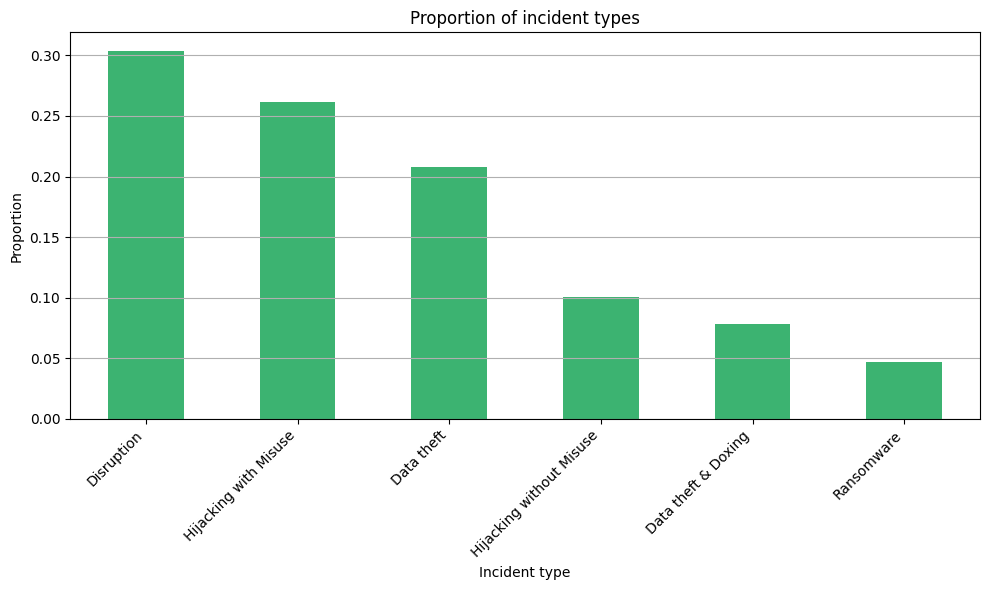

In [12]:

# ======================================================
#  Incident type proportions (weighted)
# ======================================================

df_clean["incident_type_code_list"] = (
    df_clean["incident_type_code"]
    .dropna()
    .apply(lambda x: x.split(";")))

df_clean["n_incidents"] = df_clean["incident_type_code_list"].apply(
    lambda x: len(x) if isinstance(x, list) else 0)

df_incidents_exploded = df_clean.explode("incident_type_code_list")
df_incidents_exploded["weight"] = 1 / df_incidents_exploded["n_incidents"]

incident_weights = (
    df_incidents_exploded
    .groupby("incident_type_code_list")["weight"]
    .sum())

incident_proportions = (incident_weights / df_clean.shape[0]).sort_values(ascending=False)

incident_names = {
    "1": "Data theft",
    "2": "Data theft & Doxing",
    "3": "Disruption",
    "4": "Hijacking with Misuse",
    "5": "Hijacking without Misuse",
    "6": "Ransomware",
    "7": "Other"}

incident_proportions.rename(index=incident_names).plot(
    kind="bar",
    figsize=(10, 6),
    color="mediumseagreen")

plt.title("Proportion of incident types")
plt.ylabel("Proportion")
plt.xlabel("Incident type")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


The type of incidents "Disruption", "Hijacking with misuse" and "Data theft" dominates the proportion of incidents with respectively, 30%, 25% and 20%.

Let's do a bivariate analysis of the variables incident_type et receiver_category (=sector).

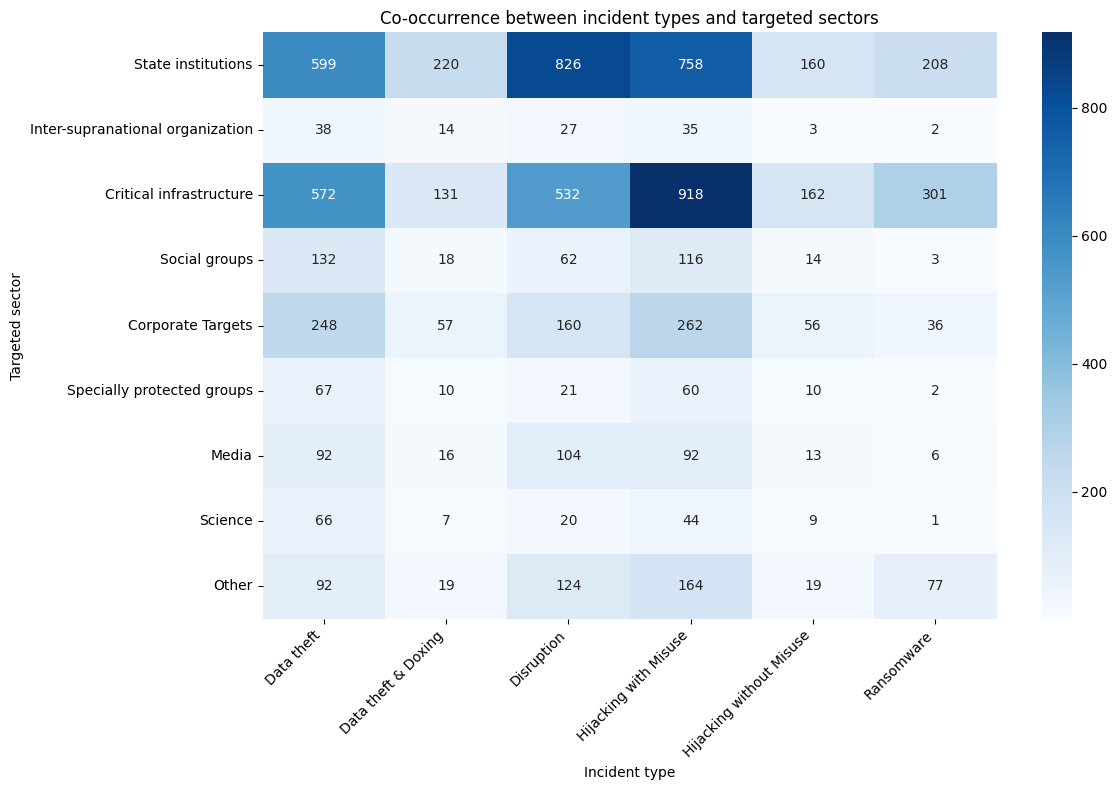

In [13]:

# ======================================================
# Co-occurrence: incident types × targeted sectors
# ======================================================

# Ensure both variables are lists
df_clean["receiver_category_code_list"] = (
    df_clean["receiver_category_code"]
    .dropna()
    .apply(lambda x: x.split(";")))

df_cross = (
    df_clean
    .explode("incident_type_code_list")
    .explode("receiver_category_code_list"))

cross_table = pd.crosstab(
    df_cross["receiver_category_code_list"],
    df_cross["incident_type_code_list"])

receiver_names = {
    "0": "Unknown",
    "1": "State institutions",
    "2": "Inter-supranational organization",
    "3": "Critical infrastructure",
    "4": "Social groups",
    "5": "Corporate Targets",
    "6": "Specially protected groups",
    "7": "Media",
    "8": "Science",
    "9": "Other"
}

cross_table.index = cross_table.index.map(receiver_names)
cross_table.columns = cross_table.columns.map(incident_names)

# Matrix 
plt.figure(figsize=(12, 8))
sns.heatmap(cross_table, annot=True, fmt="d", cmap="Blues")
plt.title("Co-occurrence between incident types and targeted sectors")
plt.xlabel("Incident type")
plt.ylabel("Targeted sector")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

We observe that the most frequent combination are the following : 
1) Critical infrastructure with Hijacking with misuse
2) State institutions with Disruption
3) State institutions with Hijacking with misuse
4) State institutions with Data theft
5) Critical infrastructure with Data theft
6) Critical infrastructure with Disruption

Now let's try to further analyze these most frequent combinations.

In [14]:

# ======================================================
# Conditional distributions
# ======================================================

# P(Sector | Incident)
cross_table_sector = cross_table.div(cross_table.sum(axis=0), axis=1)

# P(Incident | Sector)
cross_table_incident = cross_table.div(cross_table.sum(axis=1), axis=0)


In [15]:
cross_table_sector

incident_type_code_list,Data theft,Data theft & Doxing,Disruption,Hijacking with Misuse,Hijacking without Misuse,Ransomware
receiver_category_code_list,,,,,,
State institutions,0.314271,0.447154,0.440299,0.309514,0.358744,0.327044
Inter-supranational organization,0.019937,0.028455,0.014392,0.014292,0.006726,0.003145
Critical infrastructure,0.300105,0.266260,0.283582,0.374847,0.363229,0.473270
Social groups,0.069255,0.036585,0.033049,0.047366,0.031390,0.004717
Corporate Targets,0.130115,0.115854,0.085288,0.106982,0.125561,0.056604
Specially protected groups,0.035152,0.020325,0.011194,0.024500,0.022422,0.003145
Media,0.048269,0.032520,0.055437,0.037566,0.029148,0.009434
Science,0.034627,0.014228,0.010661,0.017967,0.020179,0.001572
Other,0.048269,0.038618,0.066098,0.066966,0.042601,0.121069


Among data theft attacks, 30% on state institutions, 29% are on critical infrastructure and 12.6% on corporates. \
Among data theft & doxing attacks, 43.2% on state institutions, 26.6% are on critical infrastructure and 11.5% on corporates. \
Among disruption attacks, 42.8% on state institutions and 27.9 % are on critical infrastructure. \
Among hijacking with misuse attacks, 36% are on critical infrastructure, 29.5% on state institutions and 10.7% on corporates. \
Among hijacking without misuse attacks, 32.6% on state institutions, 32% are on critical infrastructure and 11% on corporates. \
Among ransomware attacks, 44.9% are on critical infrastructure and 31% on state institutions.
Among other attacks, 75% are on critical infrastructure and 25% on corporates.

In [16]:
cross_table_incident

incident_type_code_list,Data theft,Data theft & Doxing,Disruption,Hijacking with Misuse,Hijacking without Misuse,Ransomware
receiver_category_code_list,,,,,,
State institutions,0.216167,0.079394,0.298087,0.273547,0.057741,0.075063
Inter-supranational organization,0.319328,0.117647,0.226891,0.294118,0.025210,0.016807
Critical infrastructure,0.218654,0.050076,0.203364,0.350917,0.061927,0.115061
Social groups,0.382609,0.052174,0.179710,0.336232,0.040580,0.008696
Corporate Targets,0.302808,0.069597,0.195360,0.319902,0.068376,0.043956
Specially protected groups,0.394118,0.058824,0.123529,0.352941,0.058824,0.011765
Media,0.284830,0.049536,0.321981,0.284830,0.040248,0.018576
Science,0.448980,0.047619,0.136054,0.299320,0.061224,0.006803
Other,0.185859,0.038384,0.250505,0.331313,0.038384,0.155556


Among attacks on state institutions / political system, 29.3 % are disruption, 27.5 % are hijacking with misuse and 21.7 % are data theft. \
Among attacks on international/supranational organizations, 31.9 % are data theft, 29.4 % are hijacjing with misuse and 22.6 % are disruption. \
Among attacks on critical infrastructures, 35.2 % are hijacking with misuse, 21.7 % are data theft and 20 % are disruption. \
Among attacks on social groups, 37.9 % are data theft, 33.7 % are hijacking with misuse and 17.6 % are disruption. \
Among attacks on corporates, 32.3 % are hijacking with misuse, 29.2 % are data theft, and 19.1 % are disruption. \
Among attacks on end users/specially protected groups, 39 % are data theft, 35.6 % are hijacking with misuse and 12.6 % are disruption. \
Among attacks on media, 31 % are disruption, 28.9 % are hijacking with misuse and 28.4 % are data theft.

Then, we analyze the sub-sectors of each sectors.

In [17]:
# ======================================================
#  Sub-sectors encoding
# ======================================================

subsector_mapping = {
    "Government / ministries": 1,
    "Legislative": 2,
    "Civil service / administration": 3,
    "Judiciary": 4,
    "Military": 5,
    "Police": 6,
    "Intelligence agencies": 7,
    "Political parties": 8,
    "Election infrastructure / related systems": 9,
    "Other (e.g., embassies)": 10,
    "Energy": 11,
    "Water": 12,
    "Transportation": 13,
    "Health": 14,
    "Chemicals": 15, 
    "Telecommunications": 16,
    "Food": 17,
    "Finance": 18,
    "Defence industry": 19,
    "Space": 20,
    "Waste Water Management": 21,
    "Critical Manufacturing": 22,
    "Other": 23,
    "Digital Provider": 24,
    "Research": 25,
    "Ethnic": 26,
    "Religious": 27,
    "Hacktivist": 28,
    "Criminal": 29,
    "Terrorist": 30,
    "Advocacy / activists (e.g. human rights organizations)": 31,
    "Political opposition / dissidents / expats": 32,
    "Other social groups": 33,
    "Not available": 34
}

def encode_multicategory(value, mapping, default_code):
    if pd.isna(value):
        return None
    categories = {v.strip() for v in str(value).split(";")}
    codes = {str(mapping.get(cat, default_code)) for cat in categories}
    return ";".join(sorted(codes))


df_clean["receiver_subcategory_code"] = df_clean["receiver_subcategory"].apply(
    lambda x: encode_multicategory(x, subsector_mapping, default_code=34))

print(df_clean[["receiver_subcategory", "receiver_subcategory_code"]].head(20))


                                 receiver_subcategory  \
0                             Government / ministries   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                           Judiciary   
5                                                Food   
6                                  Telecommunications   
7                                                 NaN   
8                                                 NaN   
9                      Civil service / administration   
10                                      Health;Health   
11                                   Defence industry   
12                                                NaN   
13                                 Telecommunications   
14                                                NaN   
15                                            Finance   
16  Advocacy / activists (e.g. 

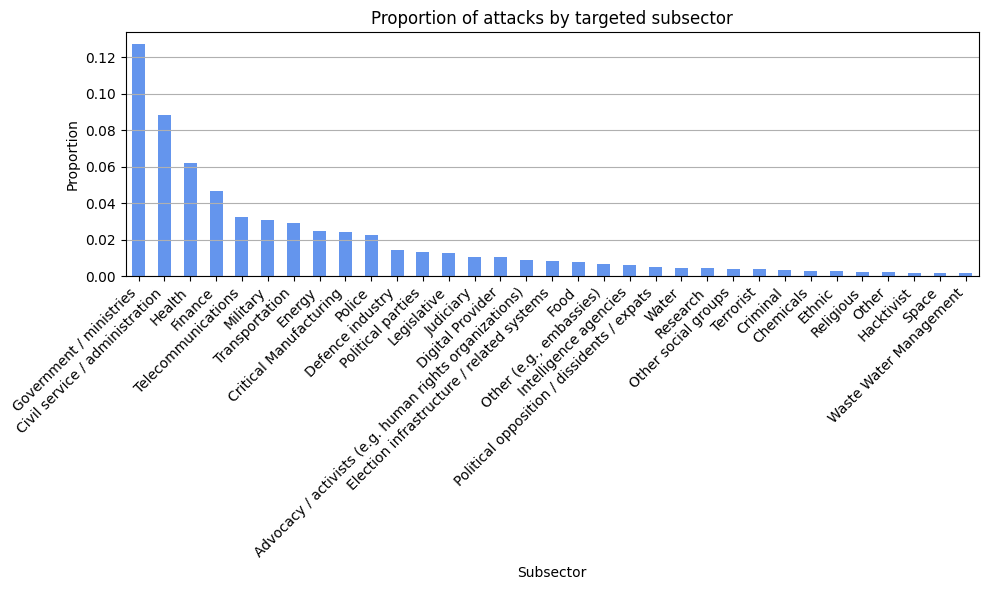

In [18]:
# ======================================================
#  Sector weighting & proportions
# ======================================================

df_clean["receiver_subcategory_code_list"] = (
    df_clean["receiver_subcategory_code"]
    .apply(lambda x: x.split(";") if isinstance(x, str) else []))

df_clean["n_subsectors"] = df_clean["receiver_subcategory_code_list"].apply(len)

df_subsector_exploded = df_clean.explode("receiver_subcategory_code_list")
df_subsector_exploded["weight"] = 1 / df_subsector_exploded["n_subsectors"]

subsector_weights = (
    df_subsector_exploded
    .groupby("receiver_subcategory_code_list")["weight"]
    .sum())

subsector_proportions = (subsector_weights / df_clean.shape[0]).sort_values(ascending=False)

subsector_names = {str(v): k for k, v in subsector_mapping.items()}

subsector_proportions.rename(index=subsector_names).plot(
    kind="bar",
    figsize=(10, 6),
    color="cornflowerblue")

plt.title("Proportion of attacks by targeted subsector")
plt.ylabel("Proportion")
plt.xlabel("Subsector")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()



The proportions are quite diversified. The main subsector is "Governement/Ministeries" with 13% of the total of attacks received.

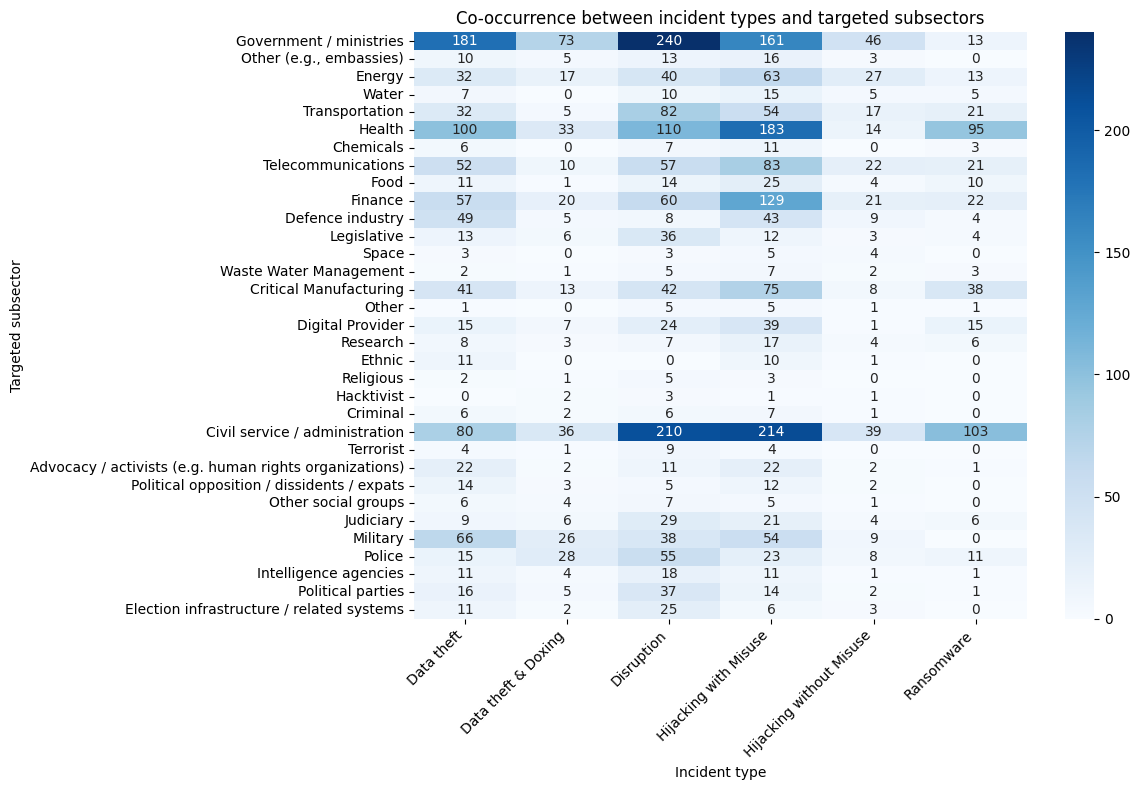

In [19]:
# ======================================================
#  Co-occurence: Sub-sectors x Incident type
# ======================================================


df_cross_subsector = (
    df_clean
    .assign(
        incident_type_code_list=lambda x: x["incident_type_code"].apply(
            lambda v: v.split(";") if isinstance(v, str) else []
        ),
        receiver_subcategory_code_list=lambda x: x["receiver_subcategory_code"].apply(
            lambda v: v.split(";") if isinstance(v, str) else []
        )
    )
    .explode("incident_type_code_list")
    .explode("receiver_subcategory_code_list"))

cross_table_subsector = pd.crosstab(
    df_cross_subsector["receiver_subcategory_code_list"],
    df_cross_subsector["incident_type_code_list"])

incident_names = {
    "1": "Data theft",
    "2": "Data theft & Doxing",
    "3": "Disruption",
    "4": "Hijacking with Misuse",
    "5": "Hijacking without Misuse",
    "6": "Ransomware",
    "7": "Other"}

cross_table_subsector.index = cross_table_subsector.index.map(subsector_names)
cross_table_subsector.columns = cross_table_subsector.columns.map(incident_names)

plt.figure(figsize=(12, 8))
sns.heatmap(cross_table_subsector, annot=True, fmt="d", cmap="Blues")
plt.title("Co-occurrence between incident types and targeted subsectors")
plt.xlabel("Incident type")
plt.ylabel("Targeted subsector")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Again, we observe some patterns: 6 main ones. They are : Government / ministries with disruption, Civil service / administration with Hijacking with misuse, Civil service / administration with disruption, Health with Hijacking with misuse, Government / ministris with Data theft and Government / ministries with Hijacking with misuse.
We compute the proportion table next.

In [20]:
# P(Subsector | Incident)
cross_table_subsector_given_incident = cross_table_subsector.div(
    cross_table_subsector.sum(axis=0), axis=1)

# P(Incident | Subsector)
cross_table_incident_given_subsector = cross_table_subsector.div(
    cross_table_subsector.sum(axis=1), axis=0)

In [21]:
cross_table_subsector_given_incident

incident_type_code_list,Data theft,Data theft & Doxing,Disruption,Hijacking with Misuse,Hijacking without Misuse,Ransomware
receiver_subcategory_code_list,,,,,,
Government / ministries,0.202688,0.227414,0.196560,0.119259,0.173585,0.032746
"Other (e.g., embassies)",0.011198,0.015576,0.010647,0.011852,0.011321,0.000000
Energy,0.035834,0.052960,0.032760,0.046667,0.101887,0.032746
Water,0.007839,0.000000,0.008190,0.011111,0.018868,0.012594
Transportation,0.035834,0.015576,0.067158,0.040000,0.064151,0.052897
Health,0.111982,0.102804,0.090090,0.135556,0.052830,0.239295
Chemicals,0.006719,0.000000,0.005733,0.008148,0.000000,0.007557
Telecommunications,0.058231,0.031153,0.046683,0.061481,0.083019,0.052897
Food,0.012318,0.003115,0.011466,0.018519,0.015094,0.025189


Among data theft attacks, 20.2% are on governments/ministries and 11.1 % are on Health subsector.\
Among data theft with doxing, 22.7% are on governments/ministries, 11.2 % on civil service / administration and 10.2 % on health subsector.\
Among disruption attacks, 19.6 % are on governments/ministries and 17.1 % on civil service / administration.\
Among hijacking with misuse, 15.8 % are on civil service / administration, 13.5 % on health subsector, 11.9 % on governments and 9.5 % on finance subsector.\
Among hijacking without misuse, 17.3 % are on goverments, 14.7 % on civil service / administration and 10.1 % on energy.\
Among ransomware, 25.9 % are on civil service / administration and 23.9 % on health subsector.

In [22]:
cross_table_incident_given_subsector

incident_type_code_list,Data theft,Data theft & Doxing,Disruption,Hijacking with Misuse,Hijacking without Misuse,Ransomware
receiver_subcategory_code_list,,,,,,
Government / ministries,0.253501,0.102241,0.336134,0.225490,0.064426,0.018207
"Other (e.g., embassies)",0.212766,0.106383,0.276596,0.340426,0.063830,0.000000
Energy,0.166667,0.088542,0.208333,0.328125,0.140625,0.067708
Water,0.166667,0.000000,0.238095,0.357143,0.119048,0.119048
Transportation,0.151659,0.023697,0.388626,0.255924,0.080569,0.099526
Health,0.186916,0.061682,0.205607,0.342056,0.026168,0.177570
Chemicals,0.222222,0.000000,0.259259,0.407407,0.000000,0.111111
Telecommunications,0.212245,0.040816,0.232653,0.338776,0.089796,0.085714
Food,0.169231,0.015385,0.215385,0.384615,0.061538,0.153846


Among attacks on governments/ministries, 33.6 % are disruption, 25.3 % are data theft and 22.5 % are hijacking with misuse.\
Among attacks on civil services, 31.3 % are hijacking with misuse, 30.7 % are disruptions, 15.1 % are ransomware and 11.7 % are data theft.\
Among attacks on health subsector, 34.2 % are hijacking with misuse, 20.5 % are disruptions, 18.6 % are data theft and 17.7 % are ransomware.

The final step of this exploration part is to explore the distribution of incidents through years, and by their duration.

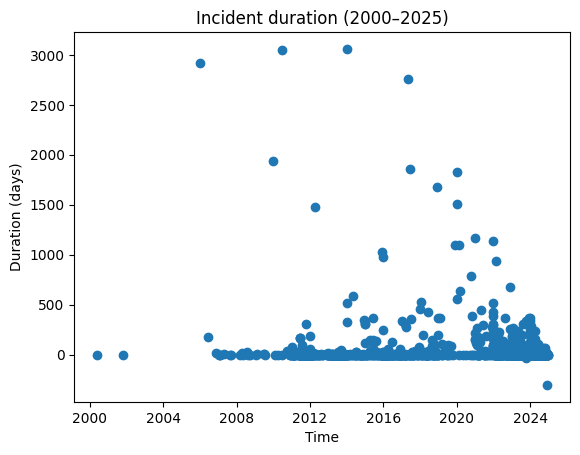

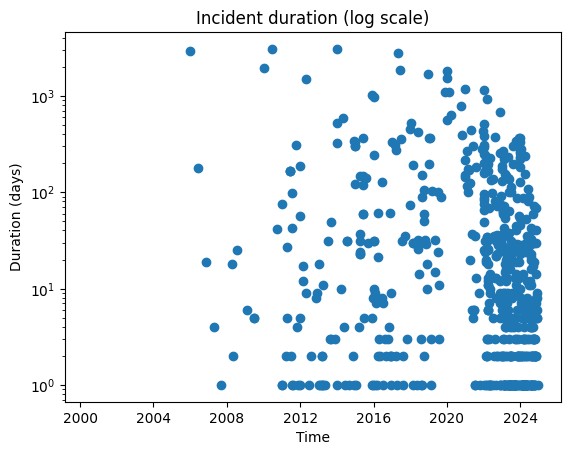

In [23]:
# ======================================================
# Incident duration over time
# ======================================================


plt.plot_date(
    df_clean["start_date"],
    df_clean["duration_incidents"])
plt.title("Incident duration (2000–2025)")
plt.xlabel("Time")
plt.ylabel("Duration (days)")
plt.show()

plt.scatter(
    df_clean["start_date"],
    df_clean["duration_incidents"])
plt.yscale("log")
plt.title("Incident duration (log scale)")
plt.xlabel("Time")
plt.ylabel("Duration (days)")
plt.show()



We can see that we have outlier value with a duration perdiod of more than 3000 days, which is very strange.\ 
Also there is one negative value, which is even stranger.
To deal with these outliers, we take the log scale, and then we will winsorize the variable "duration_incidents". \
Also, we can see that the incidents are very concentrated in the last 10 years.

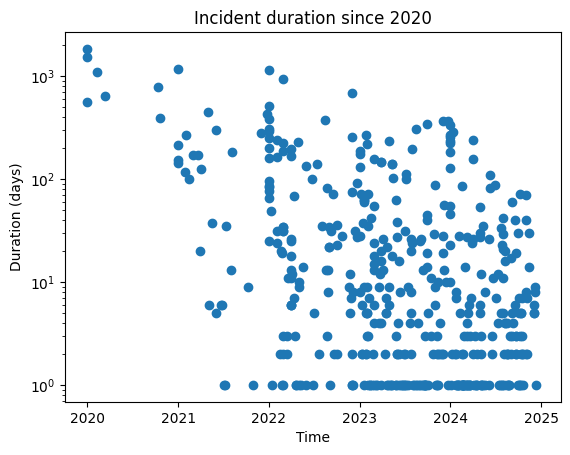

In [24]:

# ======================================================
#  Focus on post-2020 period
# ======================================================

df_2020 = df_clean[df_clean["start_date"] >= "2020-01-01"]

plt.scatter(
    df_2020["start_date"],
    df_2020["duration_incidents"])
plt.yscale("log")
plt.title("Incident duration since 2020")
plt.xlabel("Time")
plt.ylabel("Duration (days)")
plt.show()

count    1534.000000
mean       40.964798
std       209.071938
min      -303.000000
25%         0.000000
50%         0.000000
75%         5.000000
max      3059.000000
Name: duration_incidents, dtype: float64
count    1534.000000
mean       18.134289
std        46.960465
min         0.000000
25%         0.000000
50%         0.000000
75%         5.000000
max       186.000000
Name: duration_incidents, dtype: float64


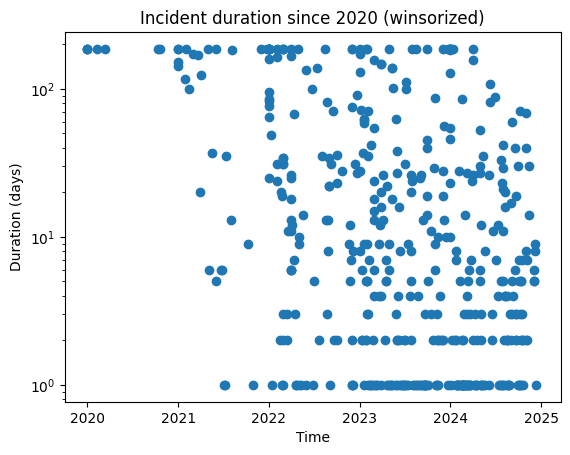

In [25]:

# ======================================================
# Winsorization of duration
# ======================================================

print(df_clean["duration_incidents"].describe())

upper = df_clean["duration_incidents"].quantile(0.95)
lower = df_clean["duration_incidents"].quantile(0.05)

df_clean["duration_incidents"] = (df_clean["duration_incidents"].clip(lower=lower, upper=upper))

print(df_clean["duration_incidents"].describe())


#  Post-winsorization visualization
df_2020 = df_clean[df_clean["start_date"] >= "2020-01-01"]

plt.scatter(
    df_2020["start_date"],
    df_2020["duration_incidents"]
)
plt.yscale("log")
plt.title("Incident duration since 2020 (winsorized)")
plt.xlabel("Time")
plt.ylabel("Duration (days)")
plt.show()

## 3.Pattern Analysis
From our previous exploration we decide to focus on 3 ways, and explore the patterns of each of them: incident type, countries and sectors.

### 3.1) Incident types and sectors

Next, we would like to deepen our analysis of pattern. Up to now, we did a macro analysis on the different sectors and began a micro analysis on the subsectors. To deepen this work, we would like to focus on the sectors with known sub-sectors (it is the most targeted sectors, beside corporates) and do the following: 
- first, we would compute two diversity indices (Shannon index and HHI index) and compare them
- then study the evolution of the these indices by computing them for different time periods

The shannon index measures the specific diversity of an environment. Is is minus the sum of proportion of individuals in an environment, times the logarithm of this proportion. It is widely used in ecology in order to assess the ecosystems' health, their biodiversity and the impacts of environmental disturbances. For low values (< 2), the ecosystem is not much diversified. For high values, it means there is a high diversity.
The HHI index measures a market concentration, used to assess competition within a market. It simply is the sum of the square of each firm market share. It varies between 0 and 10 000, with 0 being perfect competition and 10 000 a pure monopolist. An HHI index lower than 1500 means a market with a low concentration, if it is between 1500 and 2500, it is a normal level of concentration, and if it is higher than 2500, then the market is highly concentrated.

In [26]:
# ======================================================
# Diversity analysis by sector
# ======================================================

from scipy.stats import entropy

# Filter sectors of interest

df_sector1 = df_clean[
    df_clean['receiver_category_code'].str.contains('1', na=False)
].copy()  # State institutions / political system

df_sector3 = df_clean[
    df_clean['receiver_category_code'].str.contains('3', na=False)
].copy()  # Critical infrastructure

df_sector4 = df_clean[
    df_clean['receiver_category_code'].str.contains('4', na=False)
].copy()  # Social groups

print(f"Sector 1 (State institutions): {len(df_sector1)} incidents")
print(f"Sector 3 (Critical infrastructure): {len(df_sector3)} incidents")
print(f"Sector 4 (Social groups): {len(df_sector4)} incidents")


# Diversity indices function

def diversity_indices(counts):
    """
    Calculate Shannon and HHI indices from a distribution.
    
    Parameters:
    -----------
    counts : array-like
        Frequencies or counts by category
    
    Returns:
    --------
    shannon : float
        Shannon entropy index (natural log)
    hhi : float
        Herfindahl-Hirschman Index (scaled by 10,000)
    """
    # Convert to proportions
    proportions = counts / counts.sum()
    
    # Shannon index (entropy)
    shannon = entropy(proportions, base=np.e)
    
    # HHI (Herfindahl-Hirschman Index)
    hhi = np.sum(proportions**2) * 10000
    
    return shannon, hhi


# Overall diversity indices by sector

def compute_sector_diversity(df_sector, sector_name):
    """
    Compute overall diversity indices for a sector.
    """
    df_exploded = df_sector.copy()
    df_exploded["incident_type_code_list"] = (
        df_exploded["incident_type_code"]
        .dropna()
        .apply(lambda x: x.split(';'))
    )
    df_exploded = df_exploded.explode("incident_type_code_list")
    
    counts = df_exploded["incident_type_code_list"].value_counts()
    shannon, hhi = diversity_indices(counts.values)
    
    print(f"{sector_name} - Shannon: {shannon:.3f}, HHI: {hhi:.2f}")
    
    return shannon, hhi, counts


# Compute for each sector
shannon1, hhi1, counts1 = compute_sector_diversity(
    df_sector1, "State institutions / political system")

shannon3, hhi3, counts3 = compute_sector_diversity(
    df_sector3, "Critical infrastructure")

shannon4, hhi4, counts4 = compute_sector_diversity(
    df_sector4, "Social groups")

Sector 1 (State institutions): 1733 incidents
Sector 3 (Critical infrastructure): 1341 incidents
Sector 4 (Social groups): 217 incidents
State institutions / political system - Shannon: 1.607, HHI: 2256.84
Critical infrastructure - Shannon: 1.595, HHI: 2318.91
Social groups - Shannon: 1.368, HHI: 2961.81


We can see that the Shannon index is lower than 2 for all three categories, which means that the types of attacks are in general targeted to the same subsectors. Comparing with the HHI index, we find that one is above the 2500 threshold and the other two are below but close to it. Therefore, even if the HHI index for state institutions and for critical infrastructures is in the range  of normal level of concentration, both indices seem to have similar conclusions.

Now we would like to see how these indices evolve through time, in order to see if indeed the same attack patterns keep repeating. To do so, we split the data frame into several time periods, compute the indices in each period, and assess their evolution. We split into periods according to the start date of each incidents. We need to split into periods which are not too long, otherwise we won't have enough data to assess the evolution of the indices. We cannot split in calendar year, as some years have very few attacks (beginning of 2000's) and some have a lot of attacks by year (2020's). We have the same issue if we split into fixed and regular intervals. In our case, the most robust way of splitting periods is to split by a fixed number of attacks. This way, each period will have the same number of attacks, but in that case, periods will last longer in early 2000 and will shorten with years as there are more and more attacks.

In [27]:

# Temporal evolution of diversity indices

def compute_temporal_diversity(df, sector_name="All sectors", n_periods=6):
    """
    Compute diversity indices over time periods.
    
    Parameters:
    -----------
    df : DataFrame
        Sector-specific dataframe
    sector_name : str
        Name of the sector for display
    n_periods : int
        Number of periods to divide the timeline into
    
    Returns:
    --------
    results_df : DataFrame
        Shannon and HHI indices by period
    """
    df = df.copy()
    df['start_date'] = pd.to_datetime(df['start_date'])
    df_sorted = df.sort_values('start_date')
    
    # Create temporal periods based on quantiles of dates
    df_sorted['period'] = pd.qcut(
        df_sorted.index,
        q=n_periods,
        labels=[f'Period {i+1}' for i in range(n_periods)],
        duplicates='drop'
    )
    
    results = {}
    for period, group in df_sorted.groupby('period'):
        # Explode incident types
        group_exploded = group.copy()
        group_exploded["incident_type_code_list"] = (
            group_exploded["incident_type_code"]
            .dropna()
            .apply(lambda x: x.split(';'))
        )
        group_exploded = group_exploded.explode("incident_type_code_list")
        
        counts = group_exploded['incident_type_code_list'].value_counts()
        
        if len(counts) > 0:
            proportions = counts / counts.sum()
            shannon = entropy(proportions, base=np.e)
            hhi = np.sum(proportions**2) * 10000
            results[period] = {'Shannon': shannon, 'HHI': hhi}
    
    results_df = pd.DataFrame(results).T
    
    print(f"\n{sector_name} - Temporal diversity indices")
    print(results_df.round(3))
    
    return results_df

results_sector1 = compute_temporal_diversity(
    df_sector1, "State institutions / political system")

results_sector3 = compute_temporal_diversity(
    df_sector3, "Critical infrastructure")

results_sector4 = compute_temporal_diversity(
    df_sector4, "Social groups")


State institutions / political system - Temporal diversity indices
          Shannon       HHI
Period 1    1.573  2395.177
Period 2    1.586  2323.880
Period 3    1.666  2097.381
Period 4    1.515  2480.306
Period 5    1.309  3117.075
Period 6    1.303  3138.020

Critical infrastructure - Temporal diversity indices
          Shannon       HHI
Period 1    1.578  2357.711
Period 2    1.573  2408.366
Period 3    1.580  2356.755
Period 4    1.651  2153.067
Period 5    1.621  2232.530
Period 6    1.289  3195.646

Social groups - Temporal diversity indices
          Shannon       HHI
Period 1    1.493  2610.796
Period 2    1.356  3163.128
Period 3    1.319  3163.128
Period 4    1.121  3647.959
Period 5    1.272  3151.011
Period 6    1.004  4125.000


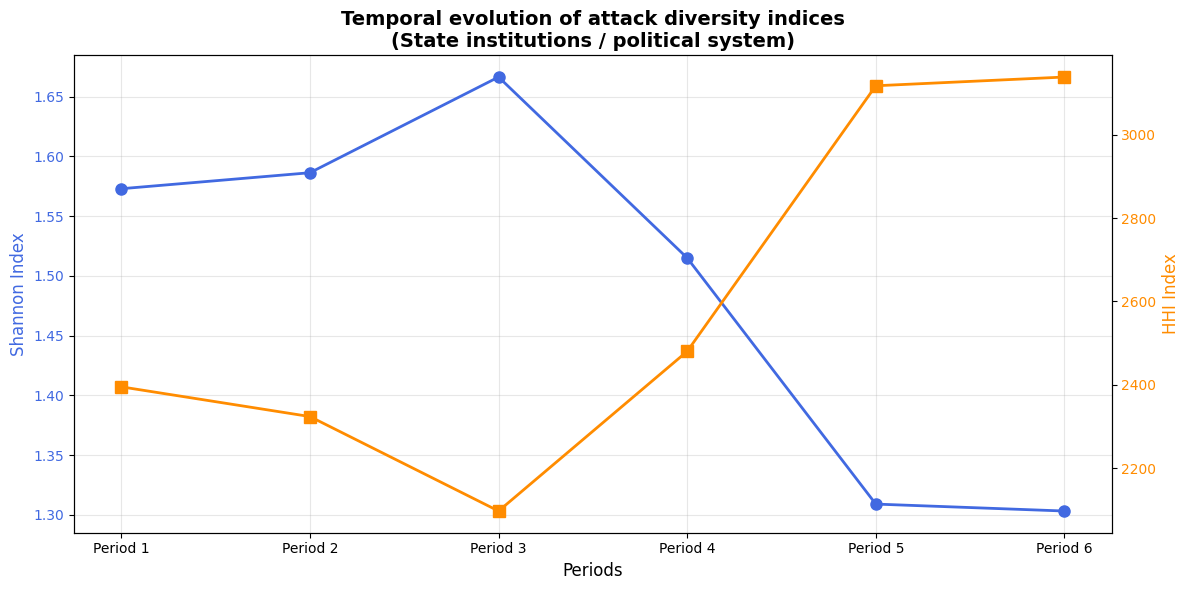

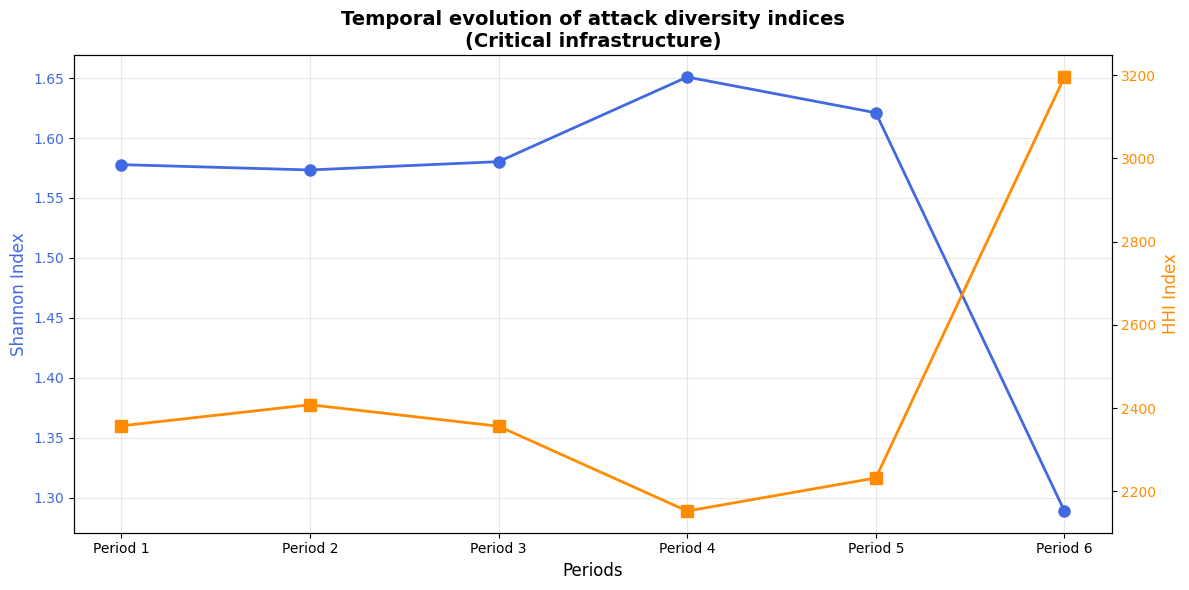

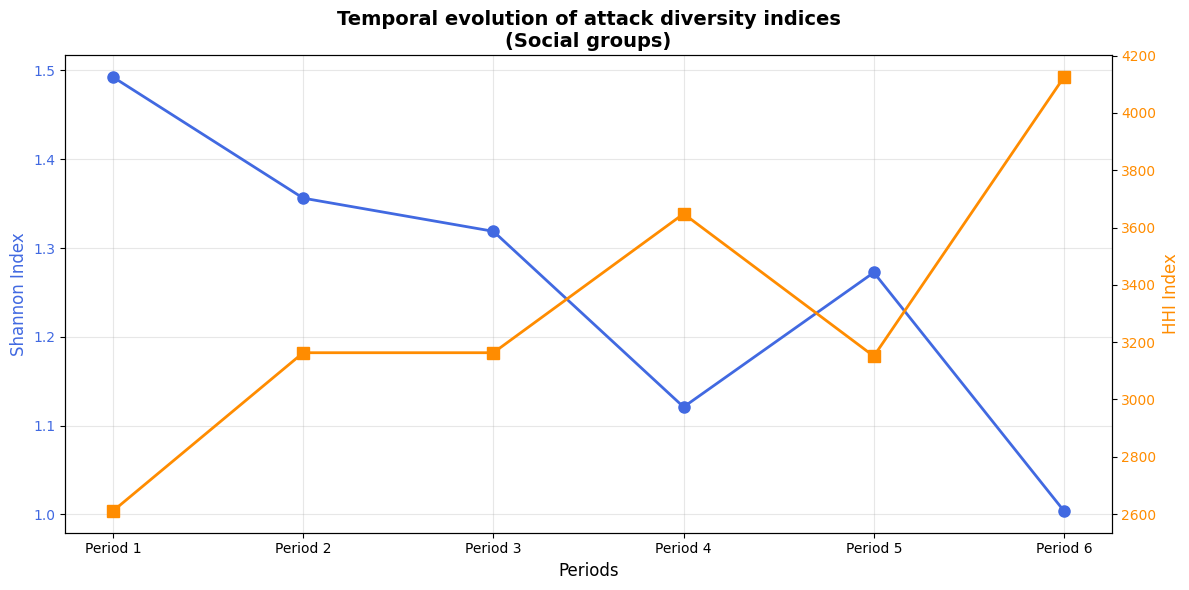

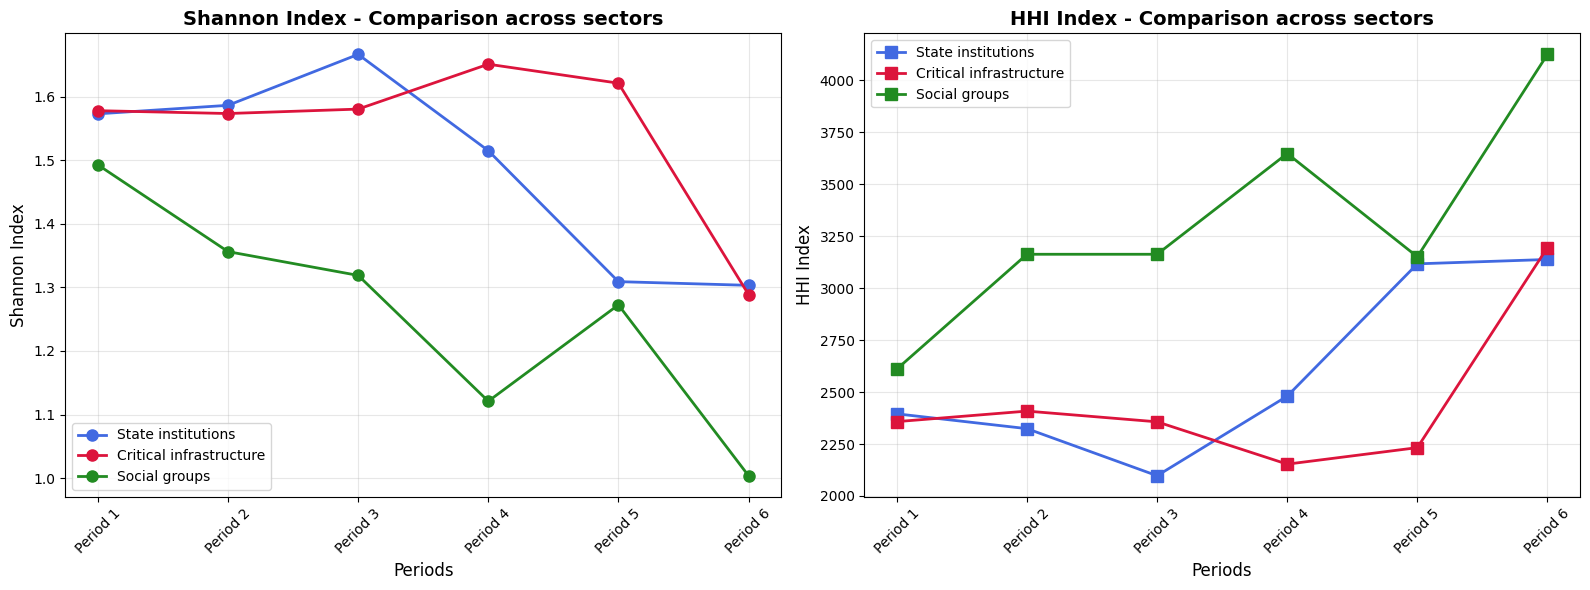

In [28]:

# Visualization function

def plot_shannon_hhi(results_df, sector_name="All sectors"):
    """
    Plot Shannon and HHI indices over time with dual y-axes.
    """
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Shannon (left axis)
    color = 'royalblue'
    ax1.set_xlabel('Periods', fontsize=12)
    ax1.set_ylabel('Shannon Index', color=color, fontsize=12)
    ax1.plot(
        results_df.index,
        results_df['Shannon'],
        marker='o',
        color=color,
        linewidth=2,
        markersize=8,
        label='Shannon'
    )
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)
    
    # HHI (right axis)
    ax2 = ax1.twinx()
    color = 'darkorange'
    ax2.set_ylabel('HHI Index', color=color, fontsize=12)
    ax2.plot(
        results_df.index,
        results_df['HHI'],
        marker='s',
        color=color,
        linewidth=2,
        markersize=8,
        label='HHI'
    )
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Title and layout
    plt.title(
        f"Temporal evolution of attack diversity indices\n({sector_name})",
        fontsize=14,
        fontweight='bold'
    )
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
    plt.show()


# ======================================================
# Generate plots for each sector
# ======================================================

plot_shannon_hhi(results_sector1, "State institutions / political system")
plot_shannon_hhi(results_sector3, "Critical infrastructure")
plot_shannon_hhi(results_sector4, "Social groups")


# ======================================================
#  Comparative visualization
# ======================================================

def plot_comparative_diversity(results_dict):
    """
    Plot Shannon and HHI for all sectors on the same graph.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    colors = ['royalblue', 'crimson', 'forestgreen']
    
    # Shannon comparison
    for (sector_name, results_df), color in zip(results_dict.items(), colors):
        ax1.plot(
            results_df.index,
            results_df['Shannon'],
            marker='o',
            color=color,
            linewidth=2,
            markersize=8,
            label=sector_name
        )
    
    ax1.set_xlabel('Periods', fontsize=12)
    ax1.set_ylabel('Shannon Index', fontsize=12)
    ax1.set_title('Shannon Index - Comparison across sectors', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # HHI comparison
    for (sector_name, results_df), color in zip(results_dict.items(), colors):
        ax2.plot(
            results_df.index,
            results_df['HHI'],
            marker='s',
            color=color,
            linewidth=2,
            markersize=8,
            label=sector_name
        )
    
    ax2.set_xlabel('Periods', fontsize=12)
    ax2.set_ylabel('HHI Index', fontsize=12)
    ax2.set_title('HHI Index - Comparison across sectors', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


# Generate comparative plot
results_dict = {
    "State institutions": results_sector1,
    "Critical infrastructure": results_sector3,
    "Social groups": results_sector4}

plot_comparative_diversity(results_dict)

We can see that the Shannon index decreases with periods for the three main sectors, which means that attacks are less and less diversified. We have similar conclusions with the evolution of the HHI index: it increases with periods. In period 6, it is even above 4000 for Social groups sector, which is well above the threshold of high concentration.

Now that we know that indeed there are patterns in the type of attacks, we need to check if it is the same patterns over time. To do so, we can study the patterns through two different measures : distribution clustering and novelty measure.

We begin first by the distributions clustering. The idea is to group into clusters the periods according to the incidents profiles. If several periods belong to the same cluster, then it means these periods have similar patterns. If new clusters appear, then there are new patterns. But to do so, we need to determine the optimal level of neighboors. We used the Elbow method, which is a technique used to determine the optimal level of clusters in K-Means. The optimal number is identified at the "elbow" point.

Period matrix sector 1 shape: (6, 6)
Period matrix sector 3 shape: (6, 6)
Period matrix sector 4 shape: (6, 6)


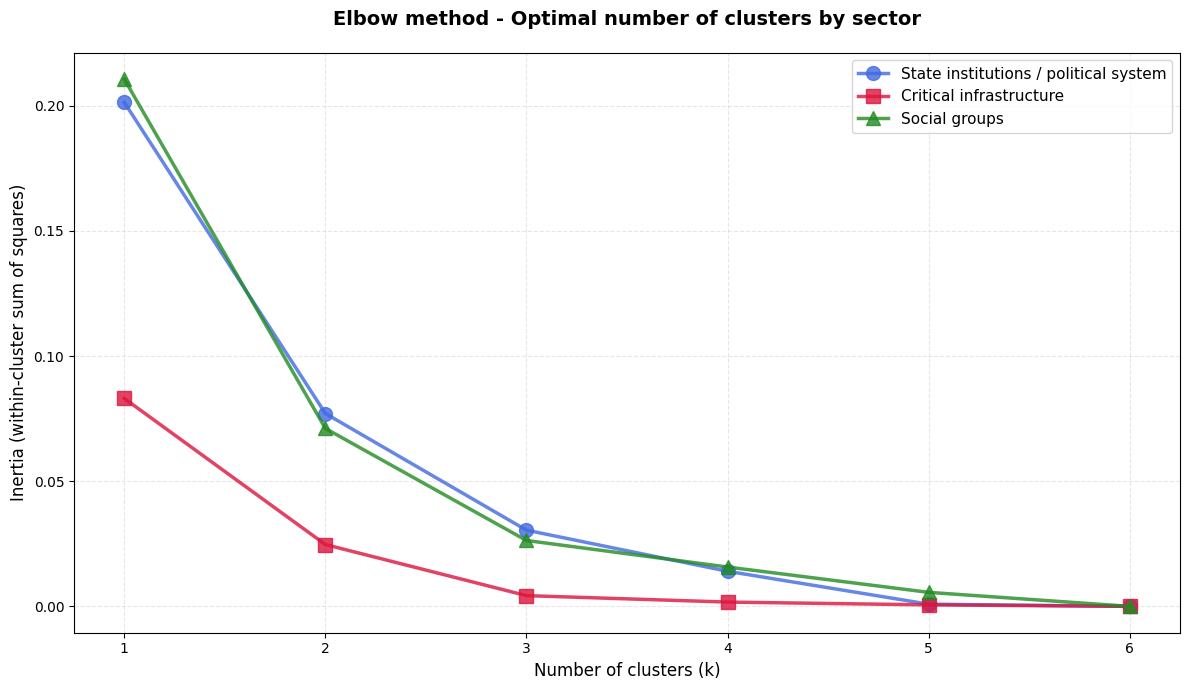

In [29]:
# ======================================================
# Clustering analysis - Elbow method
# ======================================================

from sklearn.cluster import KMeans

# Build period-incident matrix function


def build_period_matrix(df_sector, n_periods=6):
    """
    Build a matrix of incident type proportions by time period.
    
    Parameters:
    -----------
    df_sector : DataFrame
        Sector-specific dataframe
    n_periods : int
        Number of periods to divide the timeline into
    
    Returns:
    --------
    period_matrix : DataFrame
        Matrix with periods as rows and incident types as columns (proportions)
    """
    df = df_sector.copy()
    df['start_date'] = pd.to_datetime(df['start_date'])
    df = df.sort_values('start_date').reset_index(drop=True)
    
    # Create periods with equal number of observations
    df['period'] = pd.qcut(
        df.index,
        q=n_periods,
        labels=[f'Period {i+1}' for i in range(n_periods)],
        duplicates='drop')
    
    # Explode incident types for proper counting
    df["incident_type_code_list"] = (
        df["incident_type_code"]
        .dropna()
        .apply(lambda x: x.split(';')))
    df_exploded = df.explode("incident_type_code_list")
    
    # Build frequency matrix
    period_matrix = (
        df_exploded
        .groupby(['period', 'incident_type_code_list'])
        .size()
        .unstack(fill_value=0))
    
    # Convert to proportions
    period_matrix = period_matrix.div(period_matrix.sum(axis=1), axis=0)
    
    return period_matrix


# Compute elbow method for each sector

def compute_elbow_data(period_matrix, max_k=6):
    """
    Compute inertia values for different numbers of clusters.
    
    Parameters:
    -----------
    period_matrix : DataFrame
        Matrix of period × incident type proportions
    max_k : int
        Maximum number of clusters to test
    
    Returns:
    --------
    K : range
        Range of cluster numbers tested
    inertias : list
        List of inertia values for each k
    """
    inertias = []
    K = range(1, max_k + 1)
    
    for k in K:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(period_matrix)
        inertias.append(km.inertia_)
    
    return K, inertias


# Build period matrices
period_matrix_sector1 = build_period_matrix(df_sector1, n_periods=6)
period_matrix_sector3 = build_period_matrix(df_sector3, n_periods=6)
period_matrix_sector4 = build_period_matrix(df_sector4, n_periods=6)

print(f"Period matrix sector 1 shape: {period_matrix_sector1.shape}")
print(f"Period matrix sector 3 shape: {period_matrix_sector3.shape}")
print(f"Period matrix sector 4 shape: {period_matrix_sector4.shape}")

# Compute elbow data for each sector
K1, inertias1 = compute_elbow_data(period_matrix_sector1, max_k=6)
K3, inertias3 = compute_elbow_data(period_matrix_sector3, max_k=6)
K4, inertias4 = compute_elbow_data(period_matrix_sector4, max_k=6)


# Visualization

def plot_elbow_combined(sectors_data):
    """
    Plot elbow method for multiple sectors on the same graph.
    
    Parameters:
    -----------
    sectors_data : dict
        Dictionary with sector names as keys and (K, inertias) tuples as values
    """
    plt.figure(figsize=(12, 7))
    
    colors = ['royalblue', 'crimson', 'forestgreen']
    markers = ['o', 's', '^']
    
    for (sector_name, (K, inertias)), color, marker in zip(
        sectors_data.items(), colors, markers
    ):
        plt.plot(
            K,
            inertias,
            marker=marker,
            color=color,
            linewidth=2.5,
            markersize=10,
            label=sector_name,
            alpha=0.8
        )
    
    plt.title(
        "Elbow method - Optimal number of clusters by sector",
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    plt.xlabel("Number of clusters (k)", fontsize=12)
    plt.ylabel("Inertia (within-cluster sum of squares)", fontsize=12)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.xticks(K)
    plt.tight_layout()
    plt.show()


# Generate combined plot
sectors_elbow_data = {
    "State institutions / political system": (K1, inertias1),
    "Critical infrastructure": (K3, inertias3),
    "Social groups": (K4, inertias4)}

plot_elbow_combined(sectors_elbow_data)

There are not clear "elbows" but we can see that the slope becomes lower for the three sectors when k = 3.

In [30]:
# ======================================================
# K-Means clustering application
# ======================================================

from sklearn.cluster import KMeans

def apply_clustering(period_matrix, sector_name="All sectors", n_clusters=2, random_state=42):
    """
    Apply K-Means clustering to period matrix.
    
    Parameters:
    -----------
    period_matrix : DataFrame
        Matrix of period × incident type proportions
    sector_name : str
        Name of the sector for display
    n_clusters : int
        Number of clusters to create
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    period_matrix_clustered : DataFrame
        Original matrix with added 'cluster' column
    clusters : array
        Cluster assignments
    kmeans : KMeans
        Fitted KMeans model
    """
    # Fit K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(period_matrix)
    
    # Add cluster assignments to matrix
    period_matrix_clustered = period_matrix.copy()
    period_matrix_clustered['cluster'] = clusters
    
    print(f"\n{sector_name}:")
    print(f"  Number of clusters: {n_clusters}")
    print(f"  Inertia: {kmeans.inertia_:.4f}")
    print(f"\n  Cluster assignments:")
    for period in period_matrix_clustered.index:
        cluster_id = period_matrix_clustered.loc[period, 'cluster']
        print(f"    {period}: Cluster {cluster_id}")
    
    return period_matrix_clustered, clusters, kmeans


# ======================================================
# Apply clustering to each sector
# ======================================================

# State institutions / political system (3 clusters)
period_matrix_sector1_clustered, clusters1, kmeans1 = apply_clustering(
    period_matrix_sector1,
    sector_name="State institutions / political system",
    n_clusters=3,
    random_state=42)

# Critical infrastructure (4 clusters)
period_matrix_sector3_clustered, clusters3, kmeans3 = apply_clustering(
    period_matrix_sector3,
    sector_name="Critical infrastructure",
    n_clusters=3,
    random_state=42)

# Social groups (4 clusters)
period_matrix_sector4_clustered, clusters4, kmeans4 = apply_clustering(
    period_matrix_sector4,
    sector_name="Social groups",
    n_clusters=3,
    random_state=42)


# ======================================================
# Cluster profiles analysis
# ======================================================

def analyze_cluster_profiles(period_matrix_clustered, sector_name="All sectors"):
    """
    Analyze and display the profile of each cluster.
    
    Parameters:
    -----------
    period_matrix_clustered : DataFrame
        Matrix with cluster assignments
    sector_name : str
        Name of the sector for display
    """
    print(f"\n{sector_name} - Cluster profiles:")
    print("="*60)
    
    # Separate features from cluster column
    features = period_matrix_clustered.drop('cluster', axis=1)
    
    # Group by cluster and compute mean profiles
    cluster_profiles = period_matrix_clustered.groupby('cluster')[features.columns].mean()
    
    # Map incident codes to names for display
    incident_names = {
        "1": "Data theft",
        "2": "Data theft & Doxing",
        "3": "Disruption",
        "4": "Hijacking with Misuse",
        "5": "Hijacking without Misuse",
        "6": "Ransomware",
        "7": "Other"
    }
    
    # Rename columns if they match incident codes
    cluster_profiles_display = cluster_profiles.copy()
    cluster_profiles_display.columns = [
        incident_names.get(col, col) for col in cluster_profiles_display.columns
    ]
    
    print(cluster_profiles_display.round(3))
    
    # Identify dominant incident type per cluster
    print(f"\nDominant incident types by cluster:")
    for cluster_id in cluster_profiles.index:
        dominant = cluster_profiles.loc[cluster_id].idxmax()
        dominant_name = incident_names.get(dominant, dominant)
        dominant_prop = cluster_profiles.loc[cluster_id, dominant]
        print(f"  Cluster {cluster_id}: {dominant_name} ({dominant_prop:.1%})")
    
    return cluster_profiles


# Analyze cluster profiles for each sector
profiles1 = analyze_cluster_profiles(
    period_matrix_sector1_clustered,
    "State institutions / political system"
)

profiles3 = analyze_cluster_profiles(
    period_matrix_sector3_clustered,
    "Critical infrastructure"
)

profiles4 = analyze_cluster_profiles(
    period_matrix_sector4_clustered,
    "Social groups"
)


State institutions / political system:
  Number of clusters: 3
  Inertia: 0.0304

  Cluster assignments:
    Period 1: Cluster 2
    Period 2: Cluster 2
    Period 3: Cluster 0
    Period 4: Cluster 0
    Period 5: Cluster 1
    Period 6: Cluster 1

Critical infrastructure:
  Number of clusters: 3
  Inertia: 0.0043

  Cluster assignments:
    Period 1: Cluster 1
    Period 2: Cluster 2
    Period 3: Cluster 0
    Period 4: Cluster 0
    Period 5: Cluster 0
    Period 6: Cluster 0

Social groups:
  Number of clusters: 3
  Inertia: 0.0263

  Cluster assignments:
    Period 1: Cluster 1
    Period 2: Cluster 2
    Period 3: Cluster 2
    Period 4: Cluster 2
    Period 5: Cluster 0
    Period 6: Cluster 0

State institutions / political system - Cluster profiles:
         Data theft  Data theft & Doxing  Disruption  Hijacking with Misuse  \
cluster                                                                       
0             0.270                0.092       0.201                  0

Let's try to plot the clusters. We use the Principal Component Analysis to project the 6 periods in 2 dimensions.

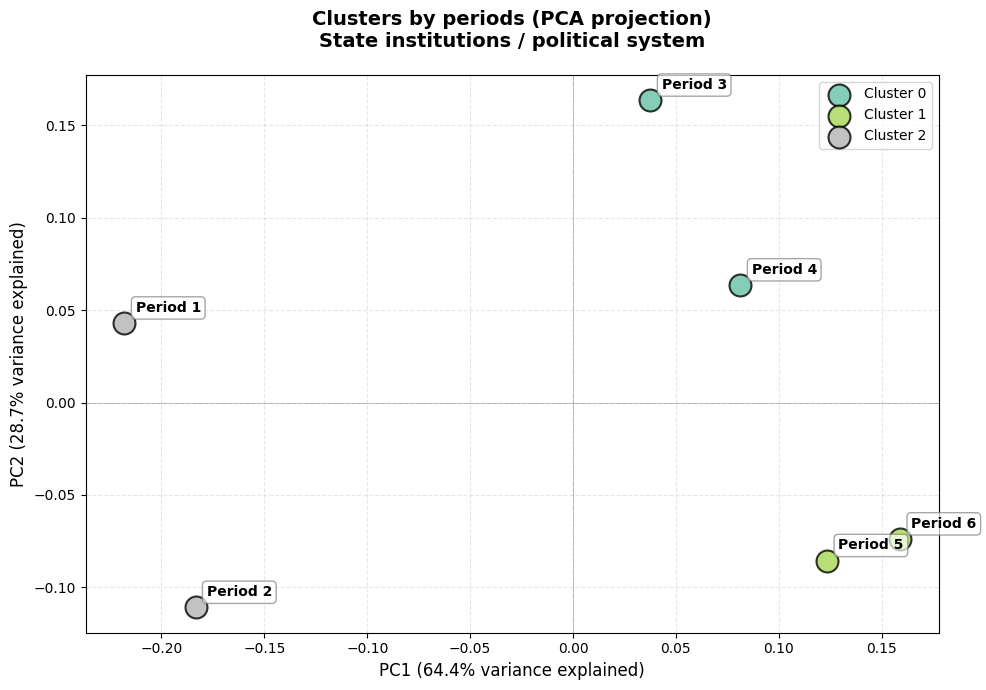


State institutions / political system:
  Total variance explained by PC1 + PC2: 93.1%
  Cluster assignments: {'Period 1': np.int32(2), 'Period 2': np.int32(2), 'Period 3': np.int32(0), 'Period 4': np.int32(0), 'Period 5': np.int32(1), 'Period 6': np.int32(1)}


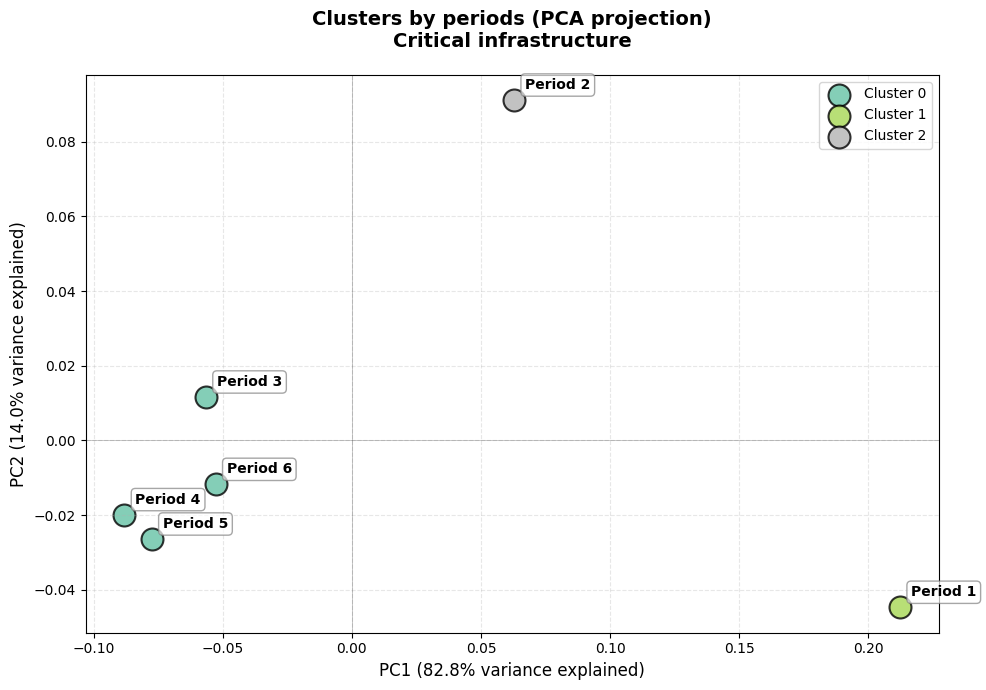


Critical infrastructure:
  Total variance explained by PC1 + PC2: 96.8%
  Cluster assignments: {'Period 1': np.int32(1), 'Period 2': np.int32(2), 'Period 3': np.int32(0), 'Period 4': np.int32(0), 'Period 5': np.int32(0), 'Period 6': np.int32(0)}


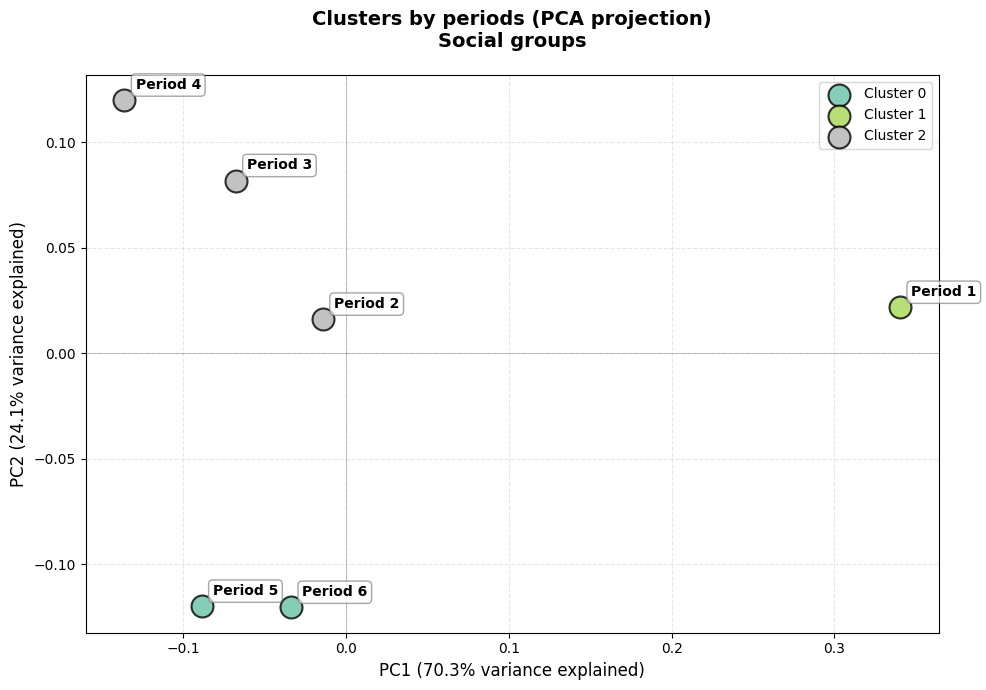


Social groups:
  Total variance explained by PC1 + PC2: 94.3%
  Cluster assignments: {'Period 1': np.int32(1), 'Period 2': np.int32(2), 'Period 3': np.int32(2), 'Period 4': np.int32(2), 'Period 5': np.int32(0), 'Period 6': np.int32(0)}


In [31]:
# ======================================================
#  PCA visualization of clusters
# ======================================================

from sklearn.decomposition import PCA

# PCA clustering visualization function

def plot_clusters_pca(period_matrix, sector_name="All sectors", n_clusters=2, random_state=42):
    """
    Visualize clusters in 2D space using PCA dimensionality reduction.
    
    Parameters:
    -----------
    period_matrix : DataFrame
        Matrix of period × incident type proportions
    sector_name : str
        Name of the sector for display
    n_clusters : int
        Number of clusters
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    period_matrix_clustered : DataFrame
        Matrix with cluster assignments
    clusters : array
        Cluster assignments
    pca : PCA
        Fitted PCA model
    coords : array
        2D coordinates after PCA transformation
    """
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(period_matrix)
    
    period_matrix_clustered = period_matrix.copy()
    period_matrix_clustered['cluster'] = clusters
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    coords = pca.fit_transform(period_matrix)
    
    # Create scatter plot
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Define color palette
    colors = plt.cm.Set2(np.linspace(0, 1, n_clusters))
    
    # Plot each cluster
    for cluster_id in range(n_clusters):
        mask = clusters == cluster_id
        ax.scatter(
            coords[mask, 0],
            coords[mask, 1],
            c=[colors[cluster_id]],
            s=250,
            edgecolor='black',
            linewidth=1.5,
            label=f'Cluster {cluster_id}',
            alpha=0.8)
    
    # Add period labels
    for i, label in enumerate(period_matrix.index):
        ax.annotate(
            label,
            (coords[i, 0], coords[i, 1]),
            xytext=(8, 8),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray', alpha=0.7))
    
    # Add explained variance to axis labels
    variance_explained = pca.explained_variance_ratio_
    ax.set_xlabel(
        f'PC1 ({variance_explained[0]:.1%} variance explained)',
        fontsize=12)
    ax.set_ylabel(
        f'PC2 ({variance_explained[1]:.1%} variance explained)',
        fontsize=12)
    
    # Styling
    ax.set_title(
        f"Clusters by periods (PCA projection)\n{sector_name}",
        fontsize=14,
        fontweight='bold',
        pad=20)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{sector_name}:")
    print(f"  Total variance explained by PC1 + PC2: {variance_explained.sum():.1%}")
    print(f"  Cluster assignments: {dict(zip(period_matrix.index, clusters))}")
    
    return period_matrix_clustered, clusters, pca, coords


# ======================================================
#  Generate PCA visualizations for each sector
# ======================================================

# State institutions / political system (3 clusters)
period_matrix_sector1_pca, clusters1_pca, pca1, coords1 = plot_clusters_pca(
    period_matrix_sector1,
    sector_name="State institutions / political system",
    n_clusters=3,
    random_state=42)

# Critical infrastructure (4 clusters)
period_matrix_sector3_pca, clusters3_pca, pca3, coords3 = plot_clusters_pca(
    period_matrix_sector3,
    sector_name="Critical infrastructure",
    n_clusters=3,
    random_state=42)

# Social groups (4 clusters)
period_matrix_sector4_pca, clusters4_pca, pca4, coords4 = plot_clusters_pca(
    period_matrix_sector4,
    sector_name="Social groups",
    n_clusters=3,
    random_state=42)


Each point is a period. 
Points with same color means they belong to the same cluster = similar incidents type.
For State institutions, periods 1 and 2 are within the cluster 2, periods 3 and 4 belong to cluster 0 and periods 5 and 6 to cluster 1. \
For Critical infrastructures, periods 3, 4, 5 and 6 belong to cluster 0, and each every remaining periods are each in a different cluster. \
For Social groups, periods 5 and 6 are in the same cluster (0), period 1 in cluster 1 and periods 2, 3 and 4 in cluster 2.  \
We want to know which type of attacks dominates in each cluster.

In [32]:
# ======================================================
# Cluster description and characterization
# ======================================================

# Prepare sorted dataframes with periods

def prepare_sector_df_with_periods(df_sector, n_periods=6):
    """
    Prepare sector dataframe with period assignments.
    
    Parameters:
    -----------
    df_sector : DataFrame
        Sector-specific dataframe
    n_periods : int
        Number of periods to divide the timeline into
    
    Returns:
    --------
    df_sorted : DataFrame
        Sorted dataframe with period column
    """
    df_sorted = df_sector.copy()
    df_sorted['start_date'] = pd.to_datetime(df_sorted['start_date'])
    df_sorted = df_sorted.sort_values('start_date').reset_index(drop=True)
    
    # Create periods with equal number of observations
    df_sorted['period'] = pd.qcut(
        df_sorted.index,
        q=n_periods,
        labels=[f'Period {i+1}' for i in range(n_periods)],
        duplicates='drop'
    )
    
    return df_sorted

# State institutions / political system
df_sector1_sorted = prepare_sector_df_with_periods(df_sector1, n_periods=6)
print(f"State institutions: {len(df_sector1_sorted)} incidents")

# Critical infrastructure
df_sector3_sorted = prepare_sector_df_with_periods(df_sector3, n_periods=6)
print(f"Critical infrastructure: {len(df_sector3_sorted)} incidents")

# Social groups
df_sector4_sorted = prepare_sector_df_with_periods(df_sector4, n_periods=6)
print(f"Social groups: {len(df_sector4_sorted)} incidents")


# ======================================================
#  Cluster description function
# ======================================================

def describe_clusters(period_matrix_clustered, sector_df_sorted, sector_name="All sectors"):
    """
    Describe and characterize each cluster with detailed statistics.
    
    Parameters:
    -----------
    period_matrix_clustered : DataFrame
        Matrix with cluster assignments
    sector_df_sorted : DataFrame
        Sector dataframe with period column
    sector_name : str
        Name of the sector for display
    """
    # Map incident codes to names
    incident_names = {
        "1": "Data theft",
        "2": "Data theft & Doxing",
        "3": "Disruption",
        "4": "Hijacking with Misuse",
        "5": "Hijacking without Misuse",
        "6": "Ransomware",
        "7": "Other"
    }
    
    print("\n" + "="*70)
    print(f"CLUSTER ANALYSIS: {sector_name}")
    print("="*70)
    
    for cluster_id in sorted(period_matrix_clustered['cluster'].unique()):
        # Get periods in this cluster
        periods_in_cluster = period_matrix_clustered[
            period_matrix_clustered['cluster'] == cluster_id
        ].index.tolist()
        
        print(f"\n{'─'*70}")
        print(f"CLUSTER {cluster_id}")
        print(f"{'─'*70}")
        print(f"Periods: {', '.join(periods_in_cluster)}")
        
        # Filter data for this cluster
        cluster_data = sector_df_sorted[
            sector_df_sorted['period'].isin(periods_in_cluster)
        ]
        
        print(f"Number of incidents: {len(cluster_data)}")
        
        # Get date range
        if len(cluster_data) > 0:
            min_date = cluster_data['start_date'].min()
            max_date = cluster_data['start_date'].max()
            print(f"Date range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
        
        # Explode incident types for accurate counting
        cluster_data_exploded = cluster_data.copy()
        cluster_data_exploded["incident_type_code_list"] = (
            cluster_data_exploded["incident_type_code"]
            .dropna()
            .apply(lambda x: x.split(';'))
        )
        cluster_data_exploded = cluster_data_exploded.explode("incident_type_code_list")
        
        # Top incident types
        incident_counts = cluster_data_exploded['incident_type_code_list'].value_counts()
        
        print(f"\nTop incident types:")
        for i, (code, count) in enumerate(incident_counts.head(5).items(), 1):
            incident_name = incident_names.get(code, f"Code {code}")
            proportion = count / len(cluster_data_exploded) * 100
            print(f"  {i}. {incident_name}: {count} ({proportion:.1f}%)")
        
        # Cluster profile (mean proportions)
        cluster_profile = period_matrix_clustered.loc[
            periods_in_cluster,
            period_matrix_clustered.columns != 'cluster'
        ].mean()
        
        print(f"\nCluster profile (mean proportions):")
        cluster_profile_sorted = cluster_profile.sort_values(ascending=False)
        for code, prop in cluster_profile_sorted.items():
            if prop > 0.05:  # Only show if > 5%
                incident_name = incident_names.get(code, f"Code {code}")
                print(f"  {incident_name}: {prop:.1%}")
    
    print("\n" + "="*70 + "\n")


# ======================================================
#  Generate cluster descriptions for each sector
# ======================================================

# State institutions / political system
describe_clusters(
    period_matrix_sector1_pca,
    df_sector1_sorted,
    "State institutions / political system"
)

# Critical infrastructure
describe_clusters(
    period_matrix_sector3_pca,
    df_sector3_sorted,
    "Critical infrastructure"
)

# Social groups
describe_clusters(
    period_matrix_sector4_pca,
    df_sector4_sorted,
    "Social groups"
)


# ======================================================
# Comparative cluster summary
# ======================================================

def create_cluster_summary(sectors_data):
    """
    Create a comparative summary of clusters across sectors.
    
    Parameters:
    -----------
    sectors_data : dict
        Dictionary with sector names as keys and 
        (period_matrix_clustered, df_sorted) tuples as values
    """
    incident_names = {
        "1": "Data theft",
        "2": "Data theft & Doxing",
        "3": "Disruption",
        "4": "Hijacking with Misuse",
        "5": "Hijacking without Misuse",
        "6": "Ransomware",
        "7": "Other"
    }
    
    
    summary_data = []
    
    for sector_name, (period_matrix_clustered, df_sorted) in sectors_data.items():
        n_clusters = period_matrix_clustered['cluster'].nunique()
        
        for cluster_id in range(n_clusters):
            periods_in_cluster = period_matrix_clustered[
                period_matrix_clustered['cluster'] == cluster_id
            ].index.tolist()
            
            cluster_data = df_sorted[df_sorted['period'].isin(periods_in_cluster)]
            
            # Get dominant incident type
            cluster_data_exploded = cluster_data.copy()
            cluster_data_exploded["incident_type_code_list"] = (
                cluster_data_exploded["incident_type_code"]
                .dropna()
                .apply(lambda x: x.split(';'))
            )
            cluster_data_exploded = cluster_data_exploded.explode("incident_type_code_list")
            
            if len(cluster_data_exploded) > 0:
                dominant_code = cluster_data_exploded['incident_type_code_list'].mode()[0]
                dominant_name = incident_names.get(dominant_code, f"Code {dominant_code}")
                
                summary_data.append({
                    'Sector': sector_name,
                    'Cluster': cluster_id,
                    'N_Periods': len(periods_in_cluster),
                    'N_Incidents': len(cluster_data),
                    'Dominant_Type': dominant_name
                })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    print("\n" + "="*70 + "\n")
    
    return summary_df


# Generate comparative summary
sectors_data = {
    "State institutions": (period_matrix_sector1_pca, df_sector1_sorted),
    "Critical infrastructure": (period_matrix_sector3_pca, df_sector3_sorted),
    "Social groups": (period_matrix_sector4_pca, df_sector4_sorted)
}

cluster_summary = create_cluster_summary(sectors_data)

State institutions: 1733 incidents
Critical infrastructure: 1341 incidents
Social groups: 217 incidents

CLUSTER ANALYSIS: State institutions / political system

──────────────────────────────────────────────────────────────────────
CLUSTER 0
──────────────────────────────────────────────────────────────────────
Periods: Period 3, Period 4
Number of incidents: 577
Date range: 2016-04-05 to 2023-01-19

Top incident types:
  1. Hijacking with Misuse: 273 (30.3%)
  2. Data theft: 243 (27.0%)
  3. Disruption: 181 (20.1%)
  4. Hijacking without Misuse: 86 (9.5%)
  5. Data theft & Doxing: 83 (9.2%)

Cluster profile (mean proportions):
  Hijacking with Misuse: 30.3%
  Data theft: 27.0%
  Disruption: 20.1%
  Hijacking without Misuse: 9.5%
  Data theft & Doxing: 9.2%

──────────────────────────────────────────────────────────────────────
CLUSTER 1
──────────────────────────────────────────────────────────────────────
Periods: Period 5, Period 6
Number of incidents: 578
Date range: 2023-01-20 to

If we look at the summary statistics: \
For State institutions : \
In cluster 0 and 1, the main type of attacks is Hijacking with misuse with around 30% of attacks each time. For cluster 2 it is Disruption with more than 40%

For Critical Infrastructures : \
Clusters 0 and 1 are pretty similar on all of their profile. Cluster 2 is slightly different with Data theft for the main incident type.

After proceeding to a cluster analysis, we can focus on the study of the novelty measure. The goal here is to answer the following question: To what extend does each new period introduce new patterns compared to previous ones ?\ The novelty measure will help us quantify how much incidents appear for the first time in each period. We will use the Jensen Shannon distance, which is a method used for measuring the similarity between two probability distributions. It is derived from the Jensen Shannon divergence, which is used to quantify how much two distributions diverge from a common mean distribution.


State institutions / political system - Jensen-Shannon distances:
     period  js_vs_previous  js_vs_all_previous
0  Period 2          0.1251              0.1251
1  Period 3          0.2658              0.2494
2  Period 4          0.1497              0.2452
3  Period 5          0.1941              0.2774
4  Period 6          0.0293              0.2329

Critical infrastructure - Jensen-Shannon distances:
     period  js_vs_previous  js_vs_all_previous
0  Period 2          0.1920              0.1920
1  Period 3          0.1590              0.2099
2  Period 4          0.0642              0.1761
3  Period 5          0.0468              0.1438
4  Period 6          0.0326              0.1090

Social groups - Jensen-Shannon distances:
     period  js_vs_previous  js_vs_all_previous
0  Period 2          0.2738              0.2738
1  Period 3          0.1413              0.2235
2  Period 4          0.1804              0.2399
3  Period 5          0.2835              0.2698
4  Period 6          

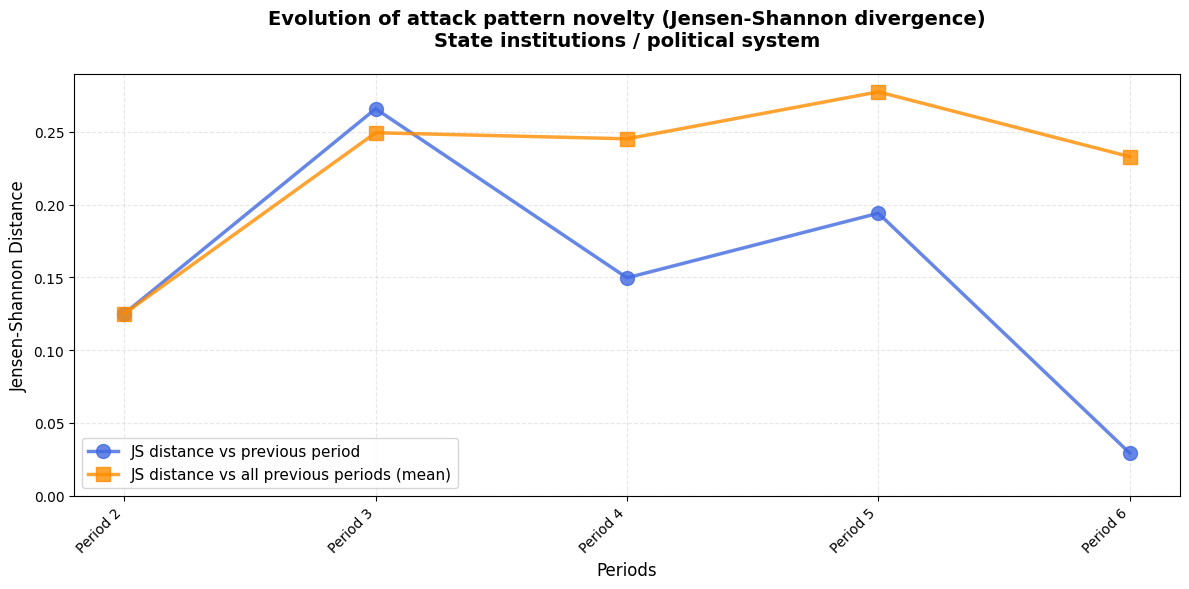

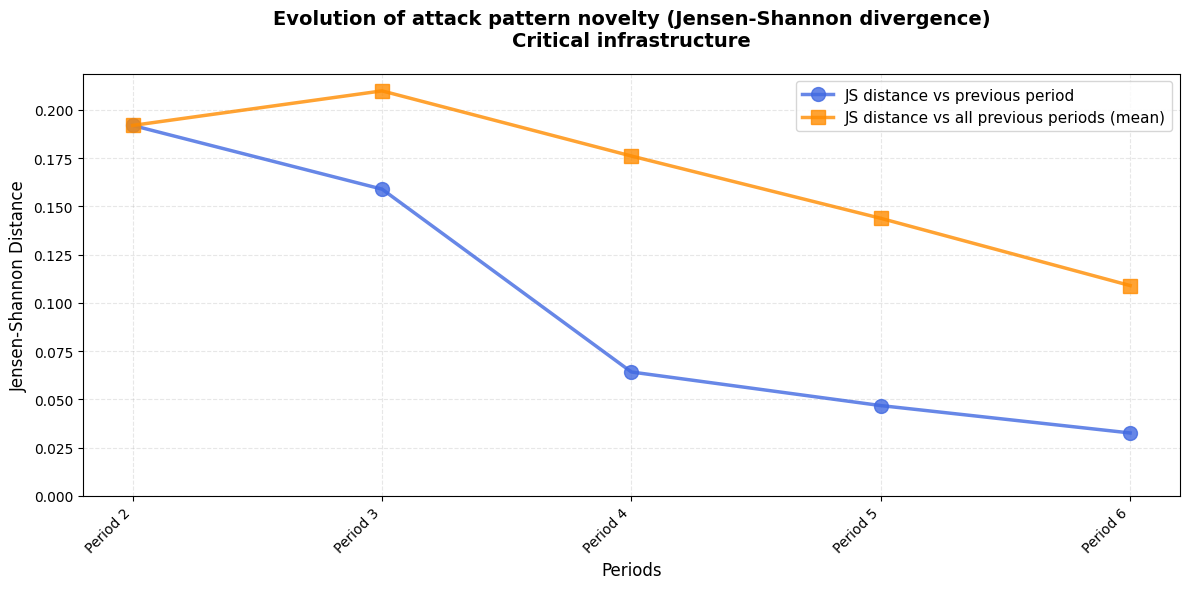

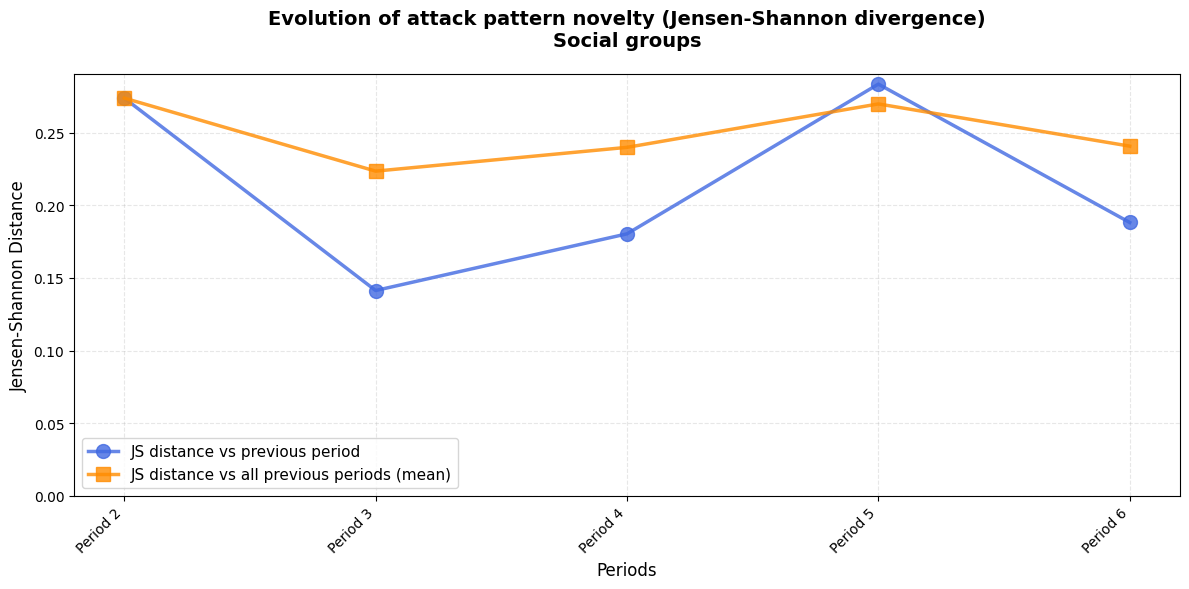

Generating comparative novelty plots


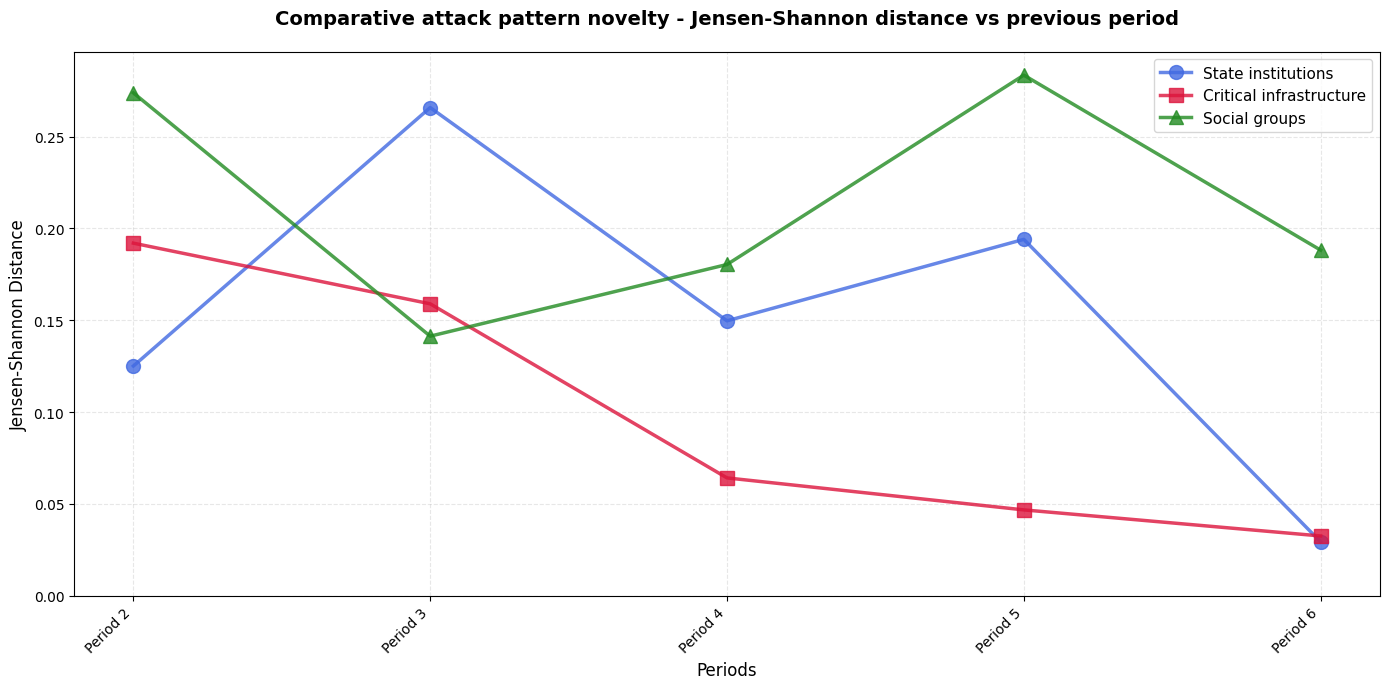

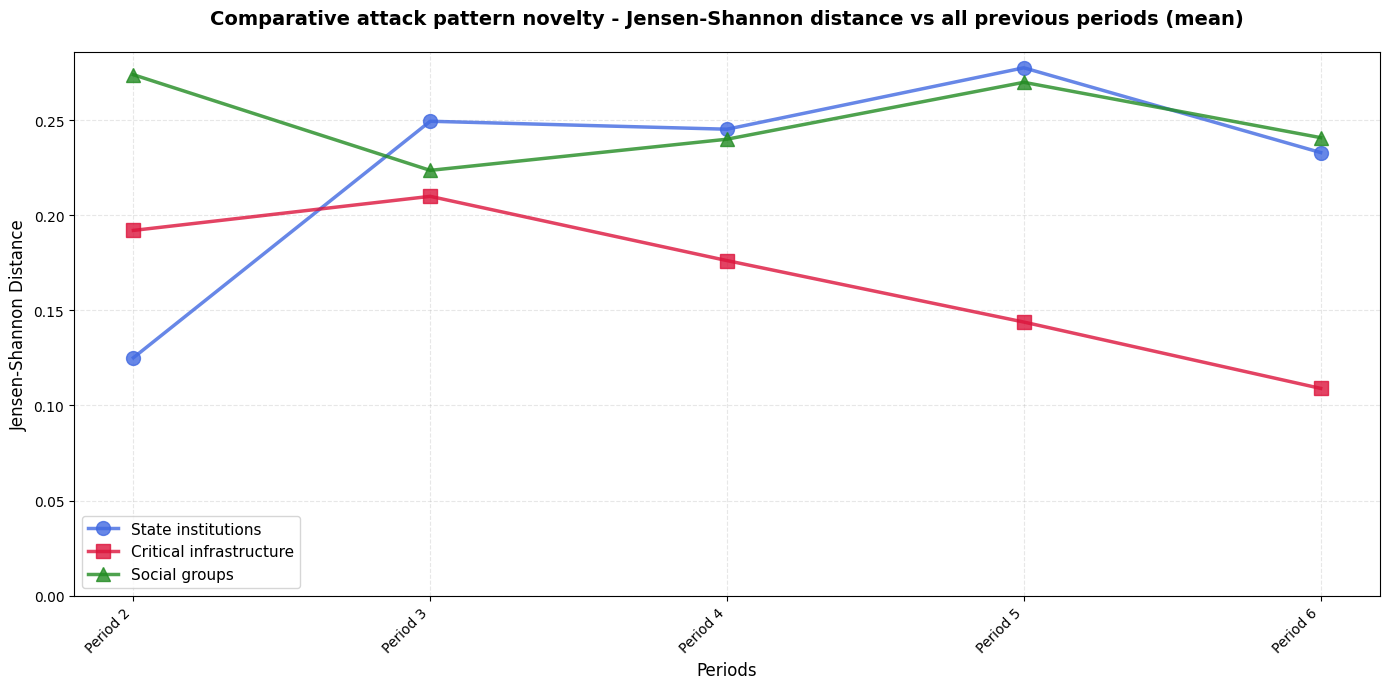

{'State institutions':      period  js_vs_previous  js_vs_all_previous
 0  Period 2        0.125090            0.125090
 1  Period 3        0.265795            0.249352
 2  Period 4        0.149703            0.245165
 3  Period 5        0.194054            0.277434
 4  Period 6        0.029333            0.232912,
 'Critical infrastructure':      period  js_vs_previous  js_vs_all_previous
 0  Period 2        0.191983            0.191983
 1  Period 3        0.158958            0.209893
 2  Period 4        0.064172            0.176126
 3  Period 5        0.046761            0.143837
 4  Period 6        0.032566            0.108975,
 'Social groups':      period  js_vs_previous  js_vs_all_previous
 0  Period 2        0.273805            0.273805
 1  Period 3        0.141337            0.223538
 2  Period 4        0.180361            0.239917
 3  Period 5        0.283464            0.269816
 4  Period 6        0.188184            0.240744}

In [33]:
# ======================================================
# Pattern novelty analysis (Jensen-Shannon distance)
# ======================================================

from scipy.spatial.distance import jensenshannon

# Jensen-Shannon novelty computation function

def compute_js_novelty(df, sector_name="All sectors"):
    """
    Compute Jensen-Shannon divergence to measure pattern novelty over time.
    
    Parameters:
    -----------
    df : DataFrame
        Dataframe with 'period' and 'incident_type_code' columns (already assigned)
    sector_name : str
        Name of the sector for display
    
    Returns:
    --------
    novelty_df : DataFrame
        DataFrame with JS distances for each period
    period_matrix : DataFrame
        Matrix of incident type proportions by period
    """
    # Explode incident types for accurate proportions
    df_exploded = df.copy()
    df_exploded["incident_type_code_list"] = (
        df_exploded["incident_type_code"]
        .dropna()
        .apply(lambda x: x.split(';'))
    )
    df_exploded = df_exploded.explode("incident_type_code_list")
    
    # Build period × incident matrix
    period_matrix = (
        df_exploded
        .groupby(['period', 'incident_type_code_list'])
        .size()
        .unstack(fill_value=0)
    )
    
    # Convert to proportions
    period_matrix = period_matrix.div(period_matrix.sum(axis=1), axis=0)
    
    periods = period_matrix.index.tolist()
    
    # Compute JS distance vs previous period
    jsd_vs_previous = []
    for i in range(1, len(periods)):
        p_prev = period_matrix.iloc[i-1].values
        p_curr = period_matrix.iloc[i].values
        dist = jensenshannon(p_prev, p_curr)
        jsd_vs_previous.append(dist)
    
    # Compute JS distance vs all previous periods (mean)
    jsd_vs_all = []
    for i in range(1, len(periods)):
        p_curr = period_matrix.iloc[i].values
        dists = [
            jensenshannon(period_matrix.iloc[j].values, p_curr)
            for j in range(i)
        ]
        jsd_vs_all.append(np.mean(dists))
    
    # Create results dataframe
    novelty_df = pd.DataFrame({
        "period": periods[1:],
        "js_vs_previous": jsd_vs_previous,
        "js_vs_all_previous": jsd_vs_all
    })
    
    print(f"\n{sector_name} - Jensen-Shannon distances:")
    print(novelty_df.round(4))
    
    return novelty_df, period_matrix


#  Compute novelty for all sectors (using existing periods)

# State institutions / political system (using df_sector1_sorted from section 23)
novelty_sector1, matrix_sector1 = compute_js_novelty(
    df_sector1_sorted,
    "State institutions / political system"
)

# Critical infrastructure (using df_sector3_sorted from section 23)
novelty_sector3, matrix_sector3 = compute_js_novelty(
    df_sector3_sorted,
    "Critical infrastructure"
)

# Social groups (using df_sector4_sorted from section 23)
novelty_sector4, matrix_sector4 = compute_js_novelty(
    df_sector4_sorted,
    "Social groups"
)


# Visualization function
def plot_js_novelty(novelty_df, sector_name="All sectors"):
    """
    Plot Jensen-Shannon distances over time.
    
    Parameters:
    -----------
    novelty_df : DataFrame
        DataFrame with JS distances
    sector_name : str
        Name of the sector for display
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot both metrics
    ax.plot(
        novelty_df["period"],
        novelty_df["js_vs_previous"],
        marker='o',
        linewidth=2.5,
        markersize=10,
        color='royalblue',
        label='JS distance vs previous period',
        alpha=0.8
    )
    
    ax.plot(
        novelty_df["period"],
        novelty_df["js_vs_all_previous"],
        marker='s',
        linewidth=2.5,
        markersize=10,
        color='darkorange',
        label='JS distance vs all previous periods (mean)',
        alpha=0.8
    )
    
    # Styling
    ax.set_title(
        f"Evolution of attack pattern novelty (Jensen-Shannon divergence)\n{sector_name}",
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    ax.set_xlabel("Periods", fontsize=12)
    ax.set_ylabel("Jensen-Shannon Distance", fontsize=12)
    ax.set_ylim(0, None)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# ======================================================
# Generate visualizations for each sector
# ======================================================

plot_js_novelty(novelty_sector1, "State institutions / political system")
plot_js_novelty(novelty_sector3, "Critical infrastructure")
plot_js_novelty(novelty_sector4, "Social groups")


#  Comparative visualization

def plot_js_novelty_comparative(novelty_data_dict, metric='js_vs_previous'):
    """
    Plot JS novelty for multiple sectors on the same graph.
    
    Parameters:
    -----------
    novelty_data_dict : dict
        Dictionary with sector names as keys and novelty DataFrames as values
    metric : str
        Which metric to plot ('js_vs_previous' or 'js_vs_all_previous')
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    
    colors = ['royalblue', 'crimson', 'forestgreen']
    markers = ['o', 's', '^']
    
    metric_label = (
        "vs previous period" if metric == 'js_vs_previous' 
        else "vs all previous periods (mean)"
    )
    
    for (sector_name, novelty_df), color, marker in zip(
        novelty_data_dict.items(), colors, markers
    ):
        ax.plot(
            novelty_df["period"],
            novelty_df[metric],
            marker=marker,
            linewidth=2.5,
            markersize=10,
            color=color,
            label=sector_name,
            alpha=0.8
        )
    
    ax.set_title(
        f"Comparative attack pattern novelty - Jensen-Shannon distance {metric_label}",
        fontsize=14,
        fontweight='bold',
        pad=20
    )
    ax.set_xlabel("Periods", fontsize=12)
    ax.set_ylabel("Jensen-Shannon Distance", fontsize=12)
    ax.set_ylim(0, None)
    ax.legend(fontsize=11, loc='best')
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Generate comparative plots
novelty_data = {
    "State institutions": novelty_sector1,
    "Critical infrastructure": novelty_sector3,
    "Social groups": novelty_sector4
}

print("Generating comparative novelty plots")

plot_js_novelty_comparative(novelty_data, metric='js_vs_previous')
plot_js_novelty_comparative(novelty_data, metric='js_vs_all_previous')

(novelty_data)

For State institutions : \
We observe a slight increase between period 2 and 3. Between periods 3 and 4, the novelty measure decreases from 0.27 to 0.15 which means some patterns seem to disapear. Then it increases slightly beween periods 4 and 5 and then there is a huge drop in period 6 (from 0.19 to 0.03).

For Critical infrastructures : \
The Jensen-Shannon distance decreases from period 1 to 6. Mainly same observation for the distance with all previous periods. But this overall decreasing trend reflects attacks less and less diversified.


For Social groups : \
For this sector, we observe lot of fluctuations bewteen periods. The distance between period 2 and 3 decreases, then between period 3 until 5 it increases for finally decreases between period 5 and 6.


### 3.2) Countries
In a second time, we want to verify if there exists patterns on countries. Indeed, if a few number of countries concentrates the majority of the cyber incidents, if there are pairs of countries (victim - attacker) that we observe more than others. Following the same goal: find if there are patterns and redundance.\
We want to check the relations between countries and the strength of these relations. The strengths will be materialized by the number of cyber attacks bewteen the countries. First, let's build a network plot.

                           attacker_country      victim_country  n_attacks
173                                   China       United States        107
603                                  Russia             Ukraine         79
607                                  Russia       United States         76
711                                 Ukraine              Russia         71
384  Korea, Democratic People's Republic of  Korea, Republic of         60
305               Iran, Islamic Republic of              Israel         54
335               Iran, Islamic Republic of       United States         45
165                                   China              Taiwan         35
479                                Pakistan               India         32
120                                   China               Japan         28


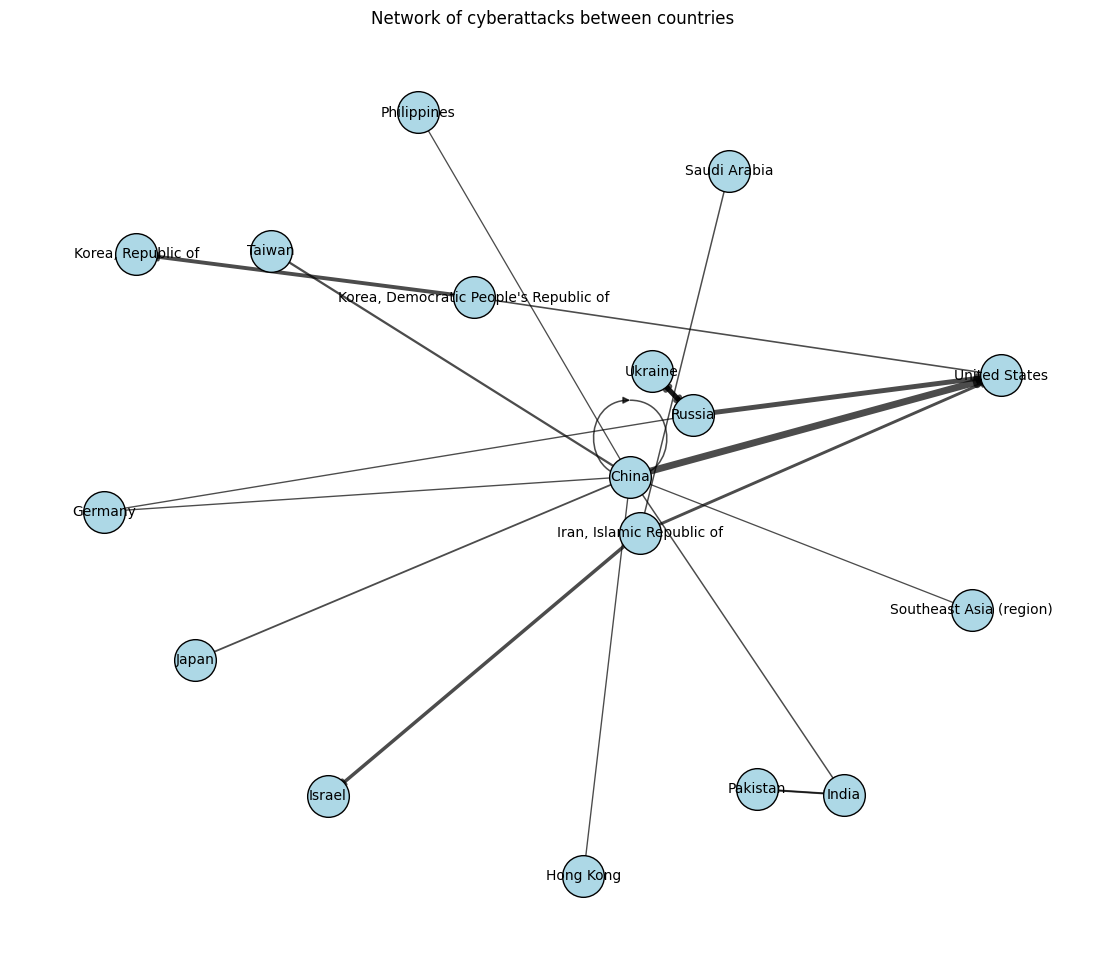

In [34]:
# ======================================================
# Country-to-country cyberattack network
# ======================================================

df_receiver_small = df_receiver[["incident_id", "receiver_country_exp"]]
df_initiator_small = df_initiator[["incident_id", "initiator_country_exp"]]

df_relations = (
    df_initiator_small
    .merge(df_receiver_small, on="incident_id", how="inner")
    .rename(columns={
        "initiator_country_exp": "attacker_country",
        "receiver_country_exp": "victim_country"
    })
)

df_edges = (
    df_relations
    .groupby(["attacker_country", "victim_country"])
    .size()
    .reset_index(name="n_attacks")
)


countries_to_remove = [
    "Europe (region)", "Global (region)", "EU (region)", "NATO (institutions)",
    "United Nations", "ISIS", "Africa", "Asia (region)", "Oceania (region)",
    "Interpol", "UNICEF", "World Anti-Doping Agency"
]

df_edges = df_edges[
    ~df_edges["attacker_country"].isin(countries_to_remove) &
    ~df_edges["victim_country"].isin(countries_to_remove)
]

df_edges = df_edges.sort_values("n_attacks", ascending=False)
print(df_edges.head(10))


# Visualisation of the Network

import networkx as nx

df_edges_filt = df_edges[df_edges["n_attacks"] >= 20]

G = nx.DiGraph()
for _, row in df_edges_filt.iterrows():
    G.add_edge(row["attacker_country"], row["victim_country"], weight=row["n_attacks"])

weights = [G[u][v]["weight"] for u, v in G.edges()]
weights_scaled = [w / max(weights) * 5 for w in weights]

pos = nx.spring_layout(G, k=1.5, seed=42)

plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G, pos, node_size=900, node_color="lightblue", edgecolors="black")
nx.draw_networkx_edges(G, pos, width=weights_scaled, arrows=True, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Network of cyberattacks between countries")
plt.axis("off")
plt.show()

We can clearly see that there is redundance in some pairs. If we check the top 5 patterns, they are :
China - USA, Russia - Ukraine, Russia - United States, Ukraine - Russia and South Korea - North Korea. And that makes sense ! 
Indeed, there are tensions betweeen China and USA for importations, a war between Ukraine and Russia, well known tensions between USA and Russia and perpetual tensions between the two Koreas.

In [35]:
# ======================================================
# Global concentration & diversity over time (attacker + victim)
# ======================================================

df_receiver["role"] = "receiver"
df_receiver["country"] = df_receiver["receiver_country"]

df_initiator["role"] = "initiator"
df_initiator["country"] = df_initiator["initiator_country"]

df_merged = pd.concat([
    df_receiver[["incident_id", "start_date", "country", "role"]],
    df_initiator[["incident_id", "start_date", "country", "role"]]
]).sort_values("start_date").reset_index(drop=True)

df_merged["period"] = pd.qcut(df_merged.index, q=6, labels=[f"P{i+1}" for i in range(6)])


# Indexes HHI and Shannon

results = []

for period, group in df_merged.groupby("period"):
    counts = group["country"].value_counts()
    shares = counts / counts.sum()

    results.append({
        "period": period,
        "avg_date": group["start_date"].mean(),
        "Shannon": entropy(shares),
        "HHI": np.sum(shares ** 2) * 10000,
        "n_obs": len(group),
        "n_countries": len(counts)
    })

df_results = pd.DataFrame(results)
print(df_results)

  period                      avg_date   Shannon         HHI  n_obs  \
0     P1 2010-01-07 10:39:05.609064960  4.833449  182.713751   1059   
1     P2 2015-01-22 21:01:42.079395072  4.868367  154.016031   1058   
2     P3 2018-06-27 07:04:39.017013248  4.877052  168.488535   1058   
3     P4 2021-12-08 01:44:48.090737152  4.505085  296.275385   1058   
4     P5 2023-05-21 07:48:12.249527296  4.335734  385.165147   1058   
5     P6 2024-05-13 01:49:32.877618432  4.463391  338.204571   1059   

   n_countries  
0          242  
1          255  
2          260  
3          239  
4          220  
5          243  


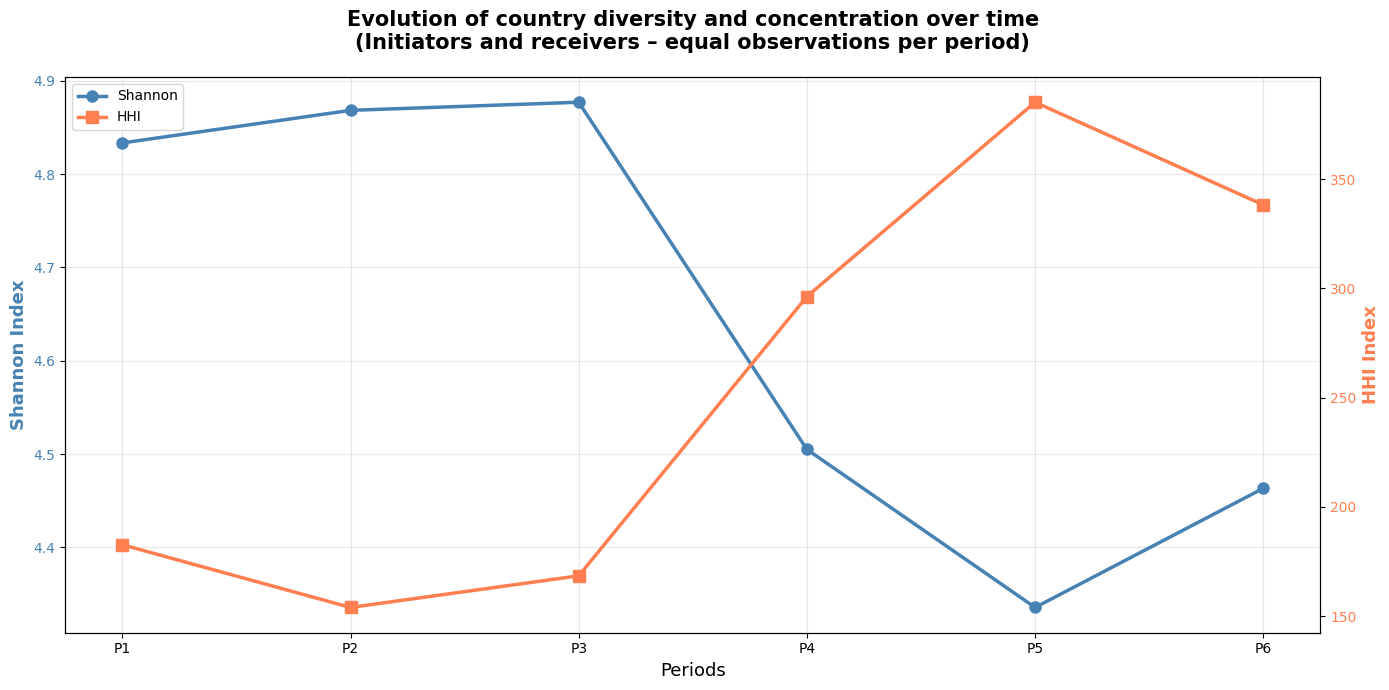

In [36]:
# Visualization
fig, ax1 = plt.subplots(figsize=(14, 7))

x = range(len(df_results))
period_labels = df_results['period'].tolist()

# Shannon
color1 = 'steelblue'
ax1.plot(
    x,
    df_results['Shannon'],
    marker='o',
    linewidth=2.5,
    markersize=8,
    color=color1,
    label='Shannon')
ax1.set_xlabel('Periods', fontsize=13)
ax1.set_ylabel('Shannon Index', color=color1, fontsize=13, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(x)
ax1.set_xticklabels(period_labels)
ax1.grid(True, alpha=0.3)

# HHI
ax2 = ax1.twinx()
color2 = 'coral'
ax2.plot(
    x,
    df_results['HHI'],
    marker='s',
    linewidth=2.5,
    markersize=8,
    color=color2,
    label='HHI')
ax2.set_ylabel('HHI Index', color=color2, fontsize=13, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color2)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(
    'Evolution of country diversity and concentration over time\n'
    '(Initiators and receivers – equal observations per period)',
    fontsize=15,
    fontweight='bold',
    pad=20)

plt.tight_layout()
plt.show()


We can see that the two indexes have an inverse relationship,  it is what we expected as one measure the diversity (Shannon) and the other measures the concentration (HHI).
For example in the first three periods the HHI was very low (< 200) meaning that the concentration was low. In the same time the Shannon was high, indicating a strong diversity.
Even if graphically we observe the opposite phenomenon for the last 3 periods, in terms of measures we observe that the HHI is still very low, meaning that there is a small concentration.
We can conclude that between the periods, the patterns of countries in terms of cyber incidents are not very concentrated.

  period  js_vs_previous  js_vs_all_previous
0     P1             NaN                 NaN
1     P2        0.588655            0.588655
2     P3        0.605390            0.623120
3     P4        0.616187            0.629812
4     P5        0.575873            0.597443
5     P6        0.463932            0.568367


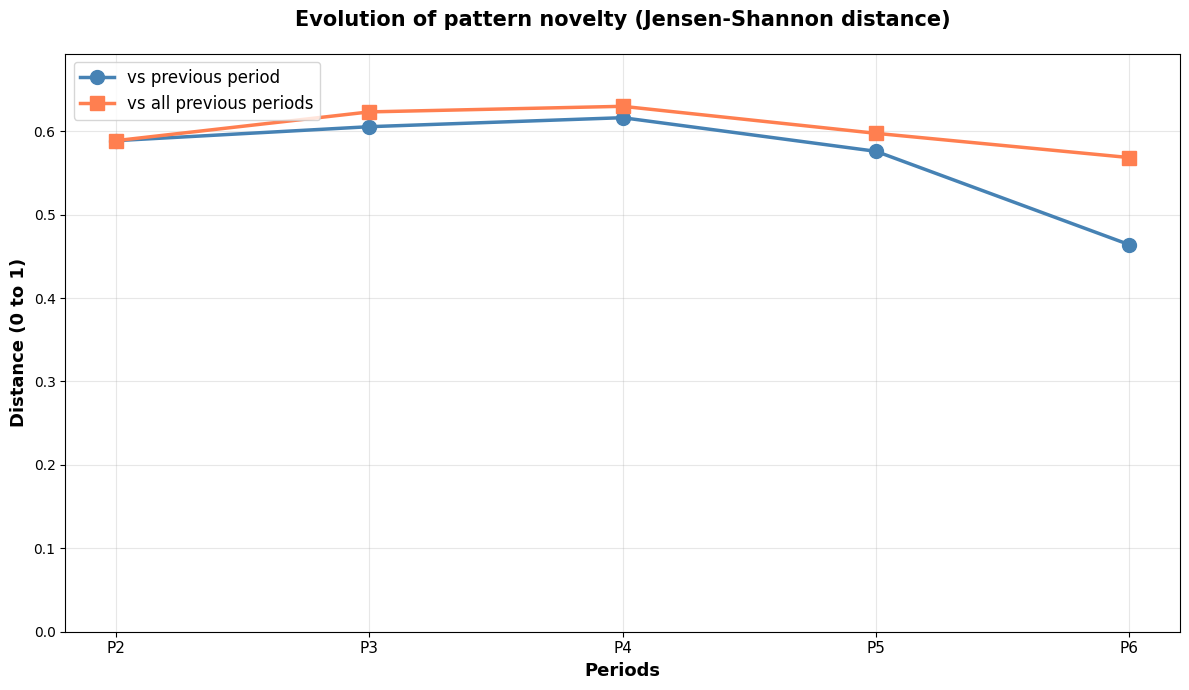

In [37]:

# ======================================================
# Novelty of attack patterns (Jensen–Shannon distance)
# ======================================================

from scipy.spatial.distance import jensenshannon


def get_distribution(df, period):
    counts = df[df["period"] == period]["country"].value_counts()
    return counts / counts.sum()


def align_distributions(d1, d2):
    all_countries = set(d1.index) | set(d2.index)
    d1 = d1.reindex(all_countries, fill_value=0)
    d2 = d2.reindex(all_countries, fill_value=0)
    return d1.values, d2.values


periods = df_merged["period"].unique()
js_prev, js_all = [], []

for i, p in enumerate(periods):
    current = get_distribution(df_merged, p)

    if i == 0:
        js_prev.append(None)
        js_all.append(None)
        continue

    prev = get_distribution(df_merged, periods[i-1])
    js_prev.append(jensenshannon(*align_distributions(current, prev)))

    js_scores = [
        jensenshannon(*align_distributions(current, get_distribution(df_merged, periods[j])))
        for j in range(i)
    ]
    js_all.append(np.mean(js_scores))

results_novelty = pd.DataFrame({
    "period": periods,
    "js_vs_previous": js_prev,
    "js_vs_all_previous": js_all
})

print(results_novelty)

# Visualization 
plot_data = results_novelty.dropna()

fig, ax = plt.subplots(figsize=(12, 7))
plot_data = results_novelty[results_novelty['js_vs_previous'].notna()]
x = range(len(plot_data))
periods_labels = plot_data['period'].tolist()

ax.plot(x, plot_data['js_vs_previous'], 'o-', 
        color='steelblue', linewidth=2.5, markersize=10, 
        label='vs previous period')

ax.plot(x, plot_data['js_vs_all_previous'], 's-', 
        color='coral', linewidth=2.5, markersize=10, 
        label='vs all previous periods')

ax.set_xlabel('Periods', fontsize=13, fontweight='bold')
ax.set_ylabel('Distance (0 to 1)', fontsize=13, fontweight='bold')
ax.set_title('Evolution of pattern novelty (Jensen-Shannon distance)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(periods_labels, fontsize=11)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(plot_data['js_vs_all_previous'].max(), 
                   plot_data['js_vs_previous'].max()) * 1.1)

plt.tight_layout()
plt.show()

In the plot, we can see that the JS distance between all the periods are high (>0.5), this indicates that the distributions are different. This indicates that there is novelty in patterns between all the periods. For example, it can be that a new actors enter in the dynamic, or that a big previous actor disapears from the dynamic.

In term of analysing the countries dynamics and patterns, the results that we obtain with the different graphs and measures converge to the same conclusion: we cannot observe a specific pattern for countries.

## III. Results and Findings

The previous work of analysis helps us to understand the dynamic on our variables of interest: countries (attacker and receiver), sectors and type of incidents. \
The goal of this last part is to wrap up our previous work by doing a final and complete analysis mixing countries, sectors and incident types. The idea is to get an overview of what we did and analysing clearly the dynamics observed. \
To remember, we wanted to answer the following problematic: Are cyber attacks becoming more diverse, or do the same attack patterns keep repeating ?


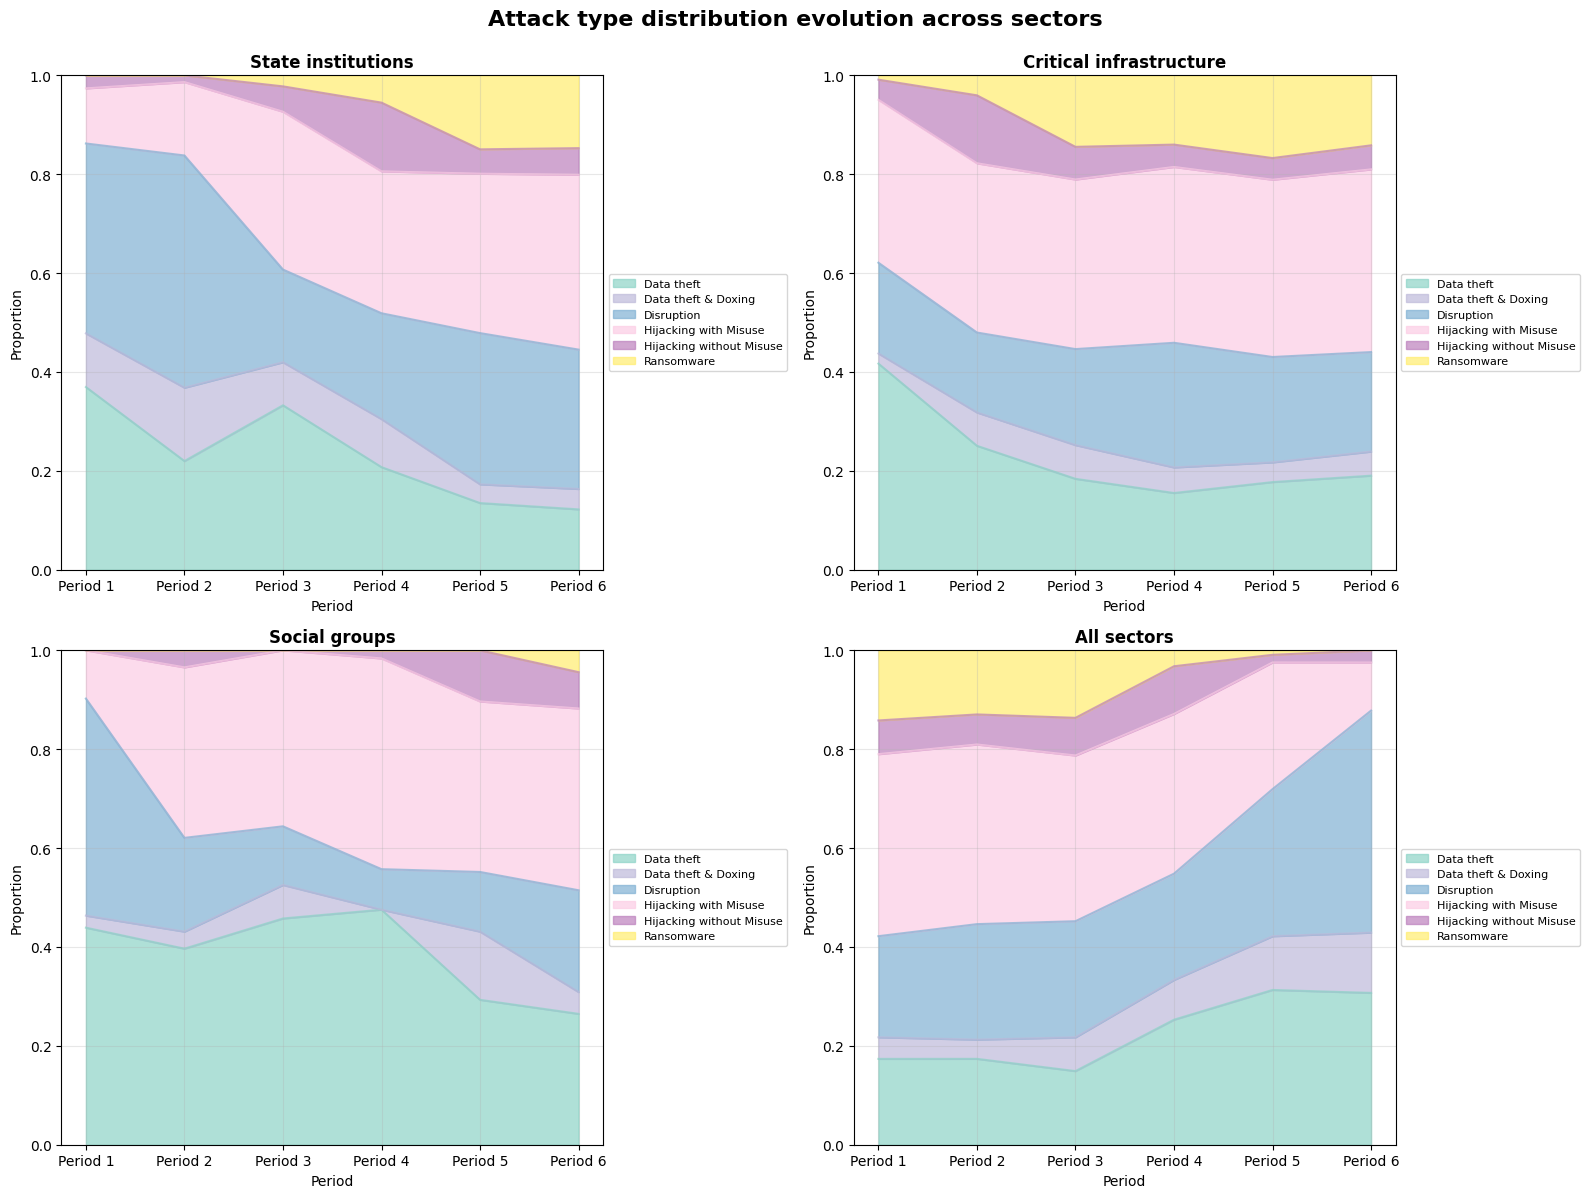

In [38]:
# ======================================================
# Cross-sectoral attack pattern evolution
# ======================================================

def analyze_sector_evolution_synthesis(sectors_dict):
    """
    Synthesize the evolution of attack patterns across all analyzed sectors.
    
    Parameters:
    -----------
    sectors_dict : dict
        Dictionary with sector names and their dataframes
    """
    # Map incident codes to names
    incident_names = {
        "1": "Data theft",
        "2": "Data theft & Doxing",
        "3": "Disruption",
        "4": "Hijacking with Misuse",
        "5": "Hijacking without Misuse",
        "6": "Ransomware",
        "7": "Other" }
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, (sector_name, df_sector) in enumerate(sectors_dict.items()):
        # Explode incident types
        df_exploded = df_sector.copy()
        df_exploded["incident_type_code_list"] = (
            df_exploded["incident_type_code"]
            .dropna()
            .apply(lambda x: x.split(';')))
        df_exploded = df_exploded.explode("incident_type_code_list")
        
        # Create period × incident matrix
        period_incident = (df_exploded.groupby(['period', 'incident_type_code_list']).size().unstack(fill_value=0))
        
        # Convert to proportions
        period_incident_prop = period_incident.div(period_incident.sum(axis=1), axis=0)
        
        # Rename columns
        period_incident_prop.columns = [incident_names.get(col, col) for col in period_incident_prop.columns]
        
        # Stacked area plot
        period_incident_prop.plot(
            kind='area',
            stacked=True,
            ax=axes[idx],
            alpha=0.7,
            colormap='Set3')
        
        axes[idx].set_title(
            f'{sector_name}',
            fontsize=12,
            fontweight='bold')
        axes[idx].set_xlabel('Period', fontsize=10)
        axes[idx].set_ylabel('Proportion', fontsize=10)
        axes[idx].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_ylim(0, 1)
    
    plt.suptitle(
        'Attack type distribution evolution across sectors',
        fontsize=16,
        fontweight='bold',
        y=0.995)
    plt.tight_layout()
    plt.show()


sectors_for_synthesis = {
    "State institutions": df_sector1_sorted,
    "Critical infrastructure": df_sector3_sorted,
    "Social groups": df_sector4_sorted,
    "All sectors": df_clean[df_clean['start_date'].notna()].assign(
        period=lambda x: pd.qcut(
            x.sort_values('start_date').reset_index(drop=True).index,
            q=6,
            labels=[f'Period {i+1}' for i in range(6)],
            duplicates='drop')).sort_values('start_date')}

analyze_sector_evolution_synthesis(sectors_for_synthesis)

These graphs illustrate the evolution that we observed earlier in the analysis. Indeed as the curves are not flat, this means that there is evolution for the 3 sectors, and globally for all the sectors. For instance, for the sector "State institutions", Hijacking with misuse was small in proportion in period 1 compared to period 6. Inversly, Data theft gets smaller in period 6.\
Globally, we can notice that ransomware is quite inexistant in period 6 and that disruption and Data theft are the "preferred" types of attacks. We can explain that ransomware quite disapears by the fact that there are only few cases where ransoms are paid, due to the risk of paying and not getting the data back for example. Also, paying is seen as a win for the cyber-attackers so victims prefer not to pay, and then it is useless for attackers to use this technique.


Temporal Complexity Index:
  period  shannon_incidents  shannon_sectors  shannon_geo  network_density  complexity_score  n_incidents
Period 1              1.593            1.372        3.654            0.009             0.830          554
Period 2              1.573            1.379        3.877            0.007             0.855          553
Period 3              1.642            1.456        3.629            0.011             0.844          554
Period 4              1.582            1.727        3.812            0.014             0.894          553
Period 5              1.422            1.715        3.984            0.015             0.894          554
Period 6              1.297            1.744        3.919            0.017             0.874          554


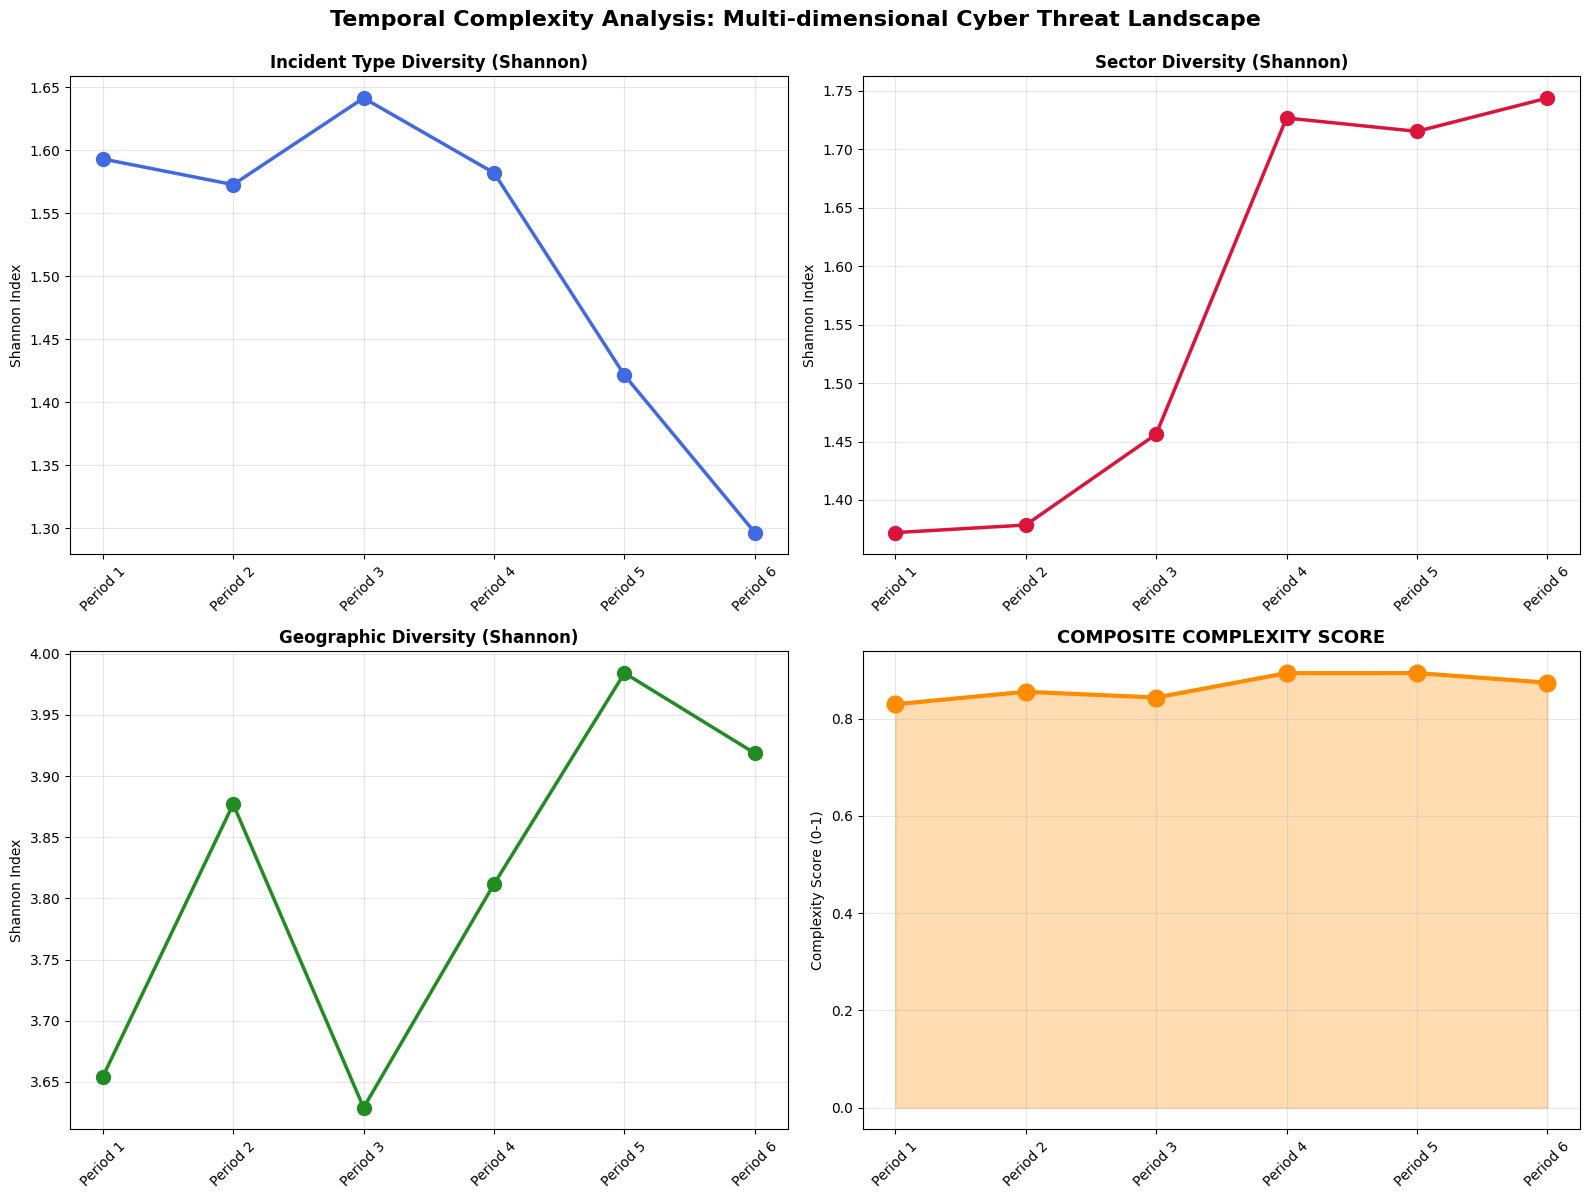

In [39]:
# ======================================================
# Temporal complexity index (combining all dimensions)
# ======================================================

def compute_temporal_complexity():
    """
    Compute a composite complexity index combining:
    - Diversity (Shannon)
    - Concentration (HHI)
    - Novelty (JS distance)
    - Network density
    """
    periods = df_sector1_sorted['period'].unique()
    
    complexity_data = []
    
    for period in periods:
        # Filter data for this period
        period_data = df_clean[
            df_clean['start_date'].notna()
        ].copy()
        period_data['period'] = pd.qcut(
            period_data.sort_values('start_date').reset_index(drop=True).index,
            q=6,
            labels=[f'Period {i+1}' for i in range(6)],
            duplicates='drop')
        
        period_data = period_data[period_data['period'] == period]
        
        if len(period_data) == 0:
            continue
        
        # Incident type diversity (Shannon)
        period_data_exp = period_data.copy()
        period_data_exp["incident_type_code_list"] = (
            period_data_exp["incident_type_code"]
            .dropna()
            .apply(lambda x: x.split(';')))
        period_data_exp = period_data_exp.explode("incident_type_code_list")
        
        incident_counts = period_data_exp['incident_type_code_list'].value_counts()
        incident_props = incident_counts / incident_counts.sum()
        shannon_incidents = entropy(incident_props, base=np.e)
        
        # Sector diversity (Shannon)
        period_data_exp2 = period_data.copy()
        period_data_exp2["receiver_category_code_list"] = (
            period_data_exp2["receiver_category_code"]
            .dropna()
            .apply(lambda x: x.split(';')))
        period_data_exp2 = period_data_exp2.explode("receiver_category_code_list")
        
        sector_counts = period_data_exp2['receiver_category_code_list'].value_counts()
        sector_props = sector_counts / sector_counts.sum()
        shannon_sectors = entropy(sector_props, base=np.e)
        
        # Geographic concentration (HHI on countries)
        # Combine initiators and receivers
        period_initiators = df_initiator[
            df_initiator['incident_id'].isin(period_data['incident_id'])
        ]['initiator_country_exp'].value_counts()
        
        period_receivers = df_receiver[
            df_receiver['incident_id'].isin(period_data['incident_id'])
        ]['receiver_country_exp'].value_counts()
        
        country_counts = pd.concat([period_initiators, period_receivers]).groupby(level=0).sum()
        country_props = country_counts / country_counts.sum()
        shannon_geo = entropy(country_props, base=np.e)
        # Network density (unique country pairs / possible pairs)
        period_edges = df_edges[
            df_edges[['attacker_country', 'victim_country']].apply(
                lambda row: any(
                    (period_data['incident_id'] == inc_id).any()
                    for inc_id in df_relations[
                        (df_relations['attacker_country'] == row['attacker_country']) &
                        (df_relations['victim_country'] == row['victim_country'])
                    ]['incident_id']
                ), axis=1)]
        
        unique_countries = set(period_initiators.index) | set(period_receivers.index)
        n_countries = len(unique_countries)
        possible_edges = n_countries * (n_countries - 1)
        
        if possible_edges > 0:
            network_density = len(period_edges) / possible_edges
        else:
            network_density = 0
        
        # Composite complexity score (normalized)
        # Higher Shannon = more complex
        # Higher density = more complex
        
        complexity_score = (
            (shannon_incidents / 2) * 0.25 +  # Normalize Shannon (max ~2)
            (shannon_sectors / 2) * 0.25 +
            (shannon_geo / 2) * 0.25 + 
            network_density * 0.25)
        
        complexity_data.append({
            'period': period,
            'shannon_incidents': shannon_incidents,
            'shannon_sectors': shannon_sectors,
            'shannon_geo': shannon_geo,
            'network_density': network_density,
            'complexity_score': complexity_score,
            'n_incidents': len(period_data)})
    
    complexity_df = pd.DataFrame(complexity_data)
    
    print("\nTemporal Complexity Index:")
    print(complexity_df.round(3).to_string(index=False))
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Shannon incidents
    axes[0, 0].plot(
        complexity_df['period'],
        complexity_df['shannon_incidents'],
        'o-',
        color='royalblue',
        linewidth=2.5,
        markersize=10)
    axes[0, 0].set_title('Incident Type Diversity (Shannon)', fontweight='bold')
    axes[0, 0].set_ylabel('Shannon Index')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Shannon sectors
    axes[0, 1].plot(
        complexity_df['period'],
        complexity_df['shannon_sectors'],
        'o-',
        color='crimson',
        linewidth=2.5,
        markersize=10)
    axes[0, 1].set_title('Sector Diversity (Shannon)', fontweight='bold')
    axes[0, 1].set_ylabel('Shannon Index')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Shannon geographic
    axes[1, 0].plot(
        complexity_df['period'],
        complexity_df['shannon_geo'],
        'o-',
        color='forestgreen',
        linewidth=2.5,
        markersize=10)
    axes[1, 0].set_title('Geographic Diversity (Shannon)', fontweight='bold')
    axes[1, 0].set_ylabel('Shannon Index')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Complexity score
    axes[1, 1].plot(
        complexity_df['period'],
        complexity_df['complexity_score'],
        'o-',
        color='darkorange',
        linewidth=3,
        markersize=12)
    axes[1, 1].fill_between(
        range(len(complexity_df)),
        complexity_df['complexity_score'],
        alpha=0.3,
        color='darkorange')
    axes[1, 1].set_title('COMPOSITE COMPLEXITY SCORE', fontweight='bold', fontsize=13)
    axes[1, 1].set_ylabel('Complexity Score (0-1)')
    axes[1, 1].set_xticks(range(len(complexity_df)))
    axes[1, 1].set_xticklabels(complexity_df['period'], rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(
        'Temporal Complexity Analysis: Multi-dimensional Cyber Threat Landscape',
        fontsize=16,
        fontweight='bold',
        y=0.995)
    plt.tight_layout()
    plt.show()
    
    return complexity_df


complexity_analysis = compute_temporal_complexity()

Finally, to aggregate all the metrics we deciced to create a metric, an index, that takes into values everything. The Shannon of incident, sectors and countries combined with a network density. We do not take into account the HHI as the Shannon index already measures the diversity and as their relation works inversaly. We arbitrary choose a ponderation equal to 0.25, so an equal ponderation, for all of the 4 metrics used to construct the complexity index. \
We can observe that this index shows no clear fluctuations and remain high, above 0.8, for all the periods. This indicates that the complexity is high, in other word there is no clear dominant typology of attacks. The diversity of sectors, of type of attacks and on targets remains very high. In this case, this is hard to be able to predict something really clear about the next attack. \
As a disclaimer, this index is only indicative and need further improvement and analysis. Indeed, it could be interesting to explore the litterature on the subject, or relative subjects, to construct a more robust indicator.

Then, an idea is to try to predict the type of incident according to the country and the sector targeted. Indeed, if we know what types of attacks will be used on a specific sector and on a specific country, we could invest to protect the victims against these specific attacks. \
For that, we will construct a (very) simple Machine Learning model to try to predict that. We expect very low performance as we saw earlier that the complexity score is high. \
The model is a multinomial logit, as we have multiple class for the type of incident.

In [40]:
#=================================================
#        Machine Learning predictive model
#=================================================

# prepare the data

df_ml = df_clean[[
    "incident_id",
    "incident_type_code",
    "receiver_category_code"
]].dropna()

df_ml["incident_type"] = df_ml["incident_type_code"].str.split(";")
df_ml["sector"] = df_ml["receiver_category_code"].str.split(";")

df_ml = df_ml.explode("incident_type").explode("sector")

# add the target country 
df_ml = df_ml.merge(
    df_receiver[["incident_id", "receiver_country_exp"]],
    on="incident_id",
    how="left"
)


# drop NA
df_ml = df_ml.dropna(subset=["receiver_country_exp"])



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


# The model (Logistic regression)
X = df_ml[["receiver_country_exp", "sector"]]
y = df_ml["incident_type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), 
         ["receiver_country_exp", "sector"])])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        multi_class="multinomial"))])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

results_ml = classification_report(y_test, y_pred)
print(results_ml)

              precision    recall  f1-score   support

           1       0.39      0.41      0.40      1117
           2       0.00      0.00      0.00       156
           3       0.31      0.12      0.17       521
           4       0.33      0.57      0.42      1141
           5       0.60      0.01      0.03       225
           6       0.00      0.00      0.00       177

    accuracy                           0.35      3337
   macro avg       0.27      0.19      0.17      3337
weighted avg       0.33      0.35      0.31      3337



We can observe a global accuracy of 0.35. The accuracy is the ratio of predicted values on total values, then the model successfuly predict 35% of the observations, which is not really good. But, as the model is simple, only relies on 3 variables and as there are many (6) types of incidents, we can also say that it is relatively good to obtain this overall performance.\
To remember, these are the 6 classes of incident type used for the model: \
        "1": "Data theft", \
        "2": "Data theft & Doxing", \
        "3": "Disruption", \
        "4": "Hijacking with Misuse", \
        "5": "Hijacking without Misuse", \
        "6": "Ransomware", \
We need to look the metrics of performance for each class. The precision is the true positive rate, the recall measures the model’s ability to find all the positive instances and the f1 score is an harmonic mean of precision and recall. \
Classes 1 and 4 have relatively good performance, with a f1 score of 0.40 and 0.42 respectively. It is the case beacause there are lots of observations for these 2 classes, more than 1000 for each, so more than 30% of the total database.\
For class 5 there is a significant drop of performance with a f1 score of 0.03. It is even worse for classes 2 and 6 with 0 performance in all the metrics. This means that the model does not succeed to predict any of these classes, this is due to the lack of obseravtions, less than 200 for each of the 2 classes. \
Finally, this phenomenon is highlighted with the average of the f1 score. We can see that the macro average is low with a value of 0.17, but when we use the weighted average we obtain 0.31 which is much higher. The performance is then dominated by the dominant classes.

For this ML model, we cannot conclude that this is not significant to predict the incident type. To increase the overall performance of our model, we could use data rebalancing techniques such as SMOTE-NC, ... 

        

To sum up, this project highlights the fact that cyber threats are hard to predict. This project illustrates the evolution of patterns through time, here between our 6 periods. On countries, there is no clear pattern repeating in every period, the novelty index of the Jensen-Shannon indicates high variation between all the periods. \
For the 3 sectors studied, it depends on the sector and on the period. For example, for each of the sectors, the HHI and Shannon indices fluctuate a lot between the periods, indicating variations. \

The idea here was to get an overview analysis of the dataset. Major improvements could be done. For example by studying the link between cyber-attacks and actual conflicts. We saw that the pair Russia-Ukraine is one of the main pair of attackers-victims. Then, it could be interesting to study this link and show that (or not) the conflict increased the number of attacks. Also, other indicators, such as macro variables for country, could be used to continue the analysis. Does the level of development have an impact on cyber-threats ? It could be that developed countries received more attacks or that it attacks more...\

Finally, an extension of this analysis could be useful for any actors in our society, specially companies and governments with sensitive data. Using analysis and predictions could help to prevent, protect and manage the threat of cyber attacks. As we know our society becomes more and more digital, indicating a raise of cyber terrorists...

Thanks for reading this code and analysis !
